In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Importing the RNN class and task dataset implementation
from train_rnn import MyRNN, train, simulate_with_lesions
from rnntaskdataset import RNNTaskDataset

# Define the hyperparameter search space
hidden_dims = [32, 64, 128, 256]
initialization_types = ['random']
g_values = [0.1, 0.5, 0.9]
nonlinearities = ['tanh','relu']
tasks = ['ready_set_go', 'delay_discrimination', 'flip_flop', 'integrator']
device='cpu'
l_percentage_of_lesions = np.linspace(0,.9,10)
num_of_runs = 30

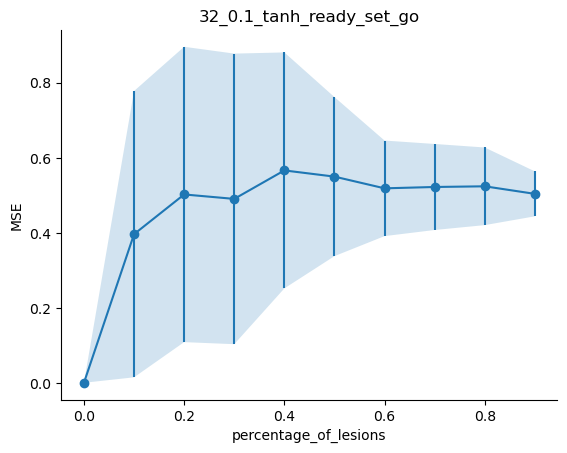

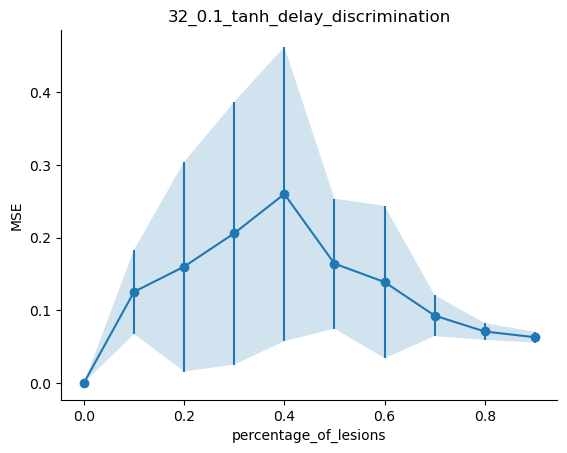

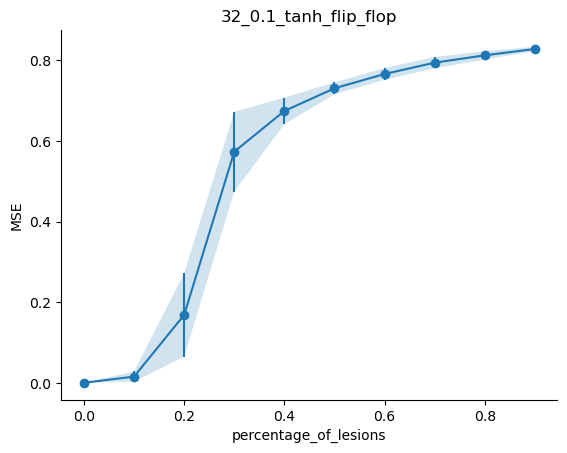

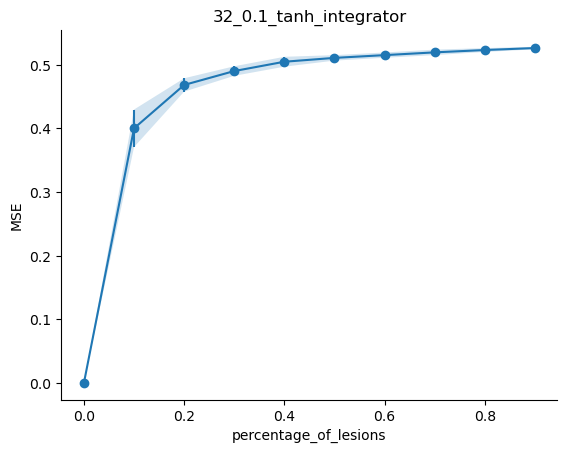

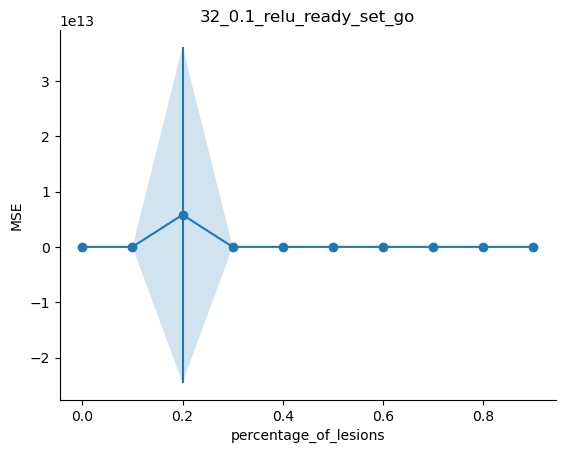

+++++++ NO NET +++++++:weights_32_random_g0.1_relu_delay_discrimination.pt


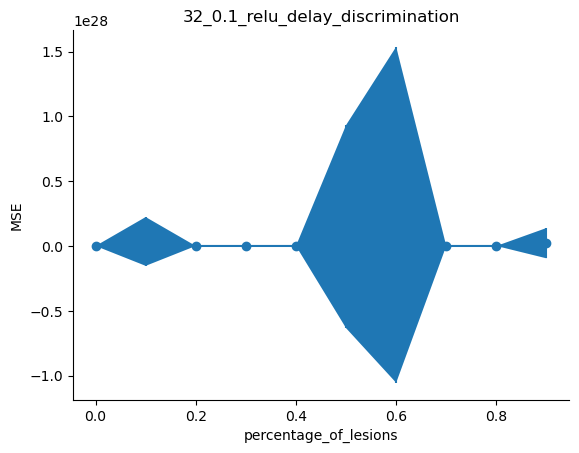

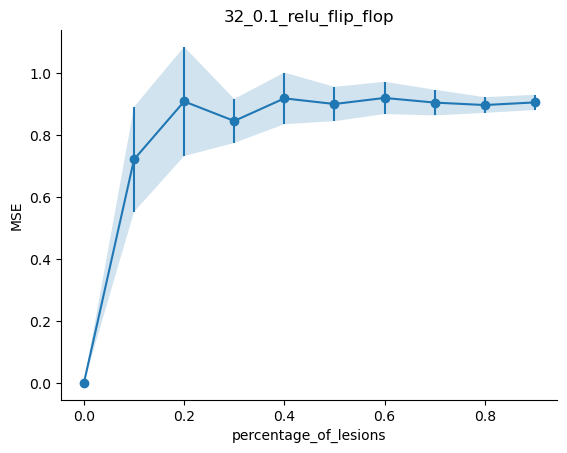

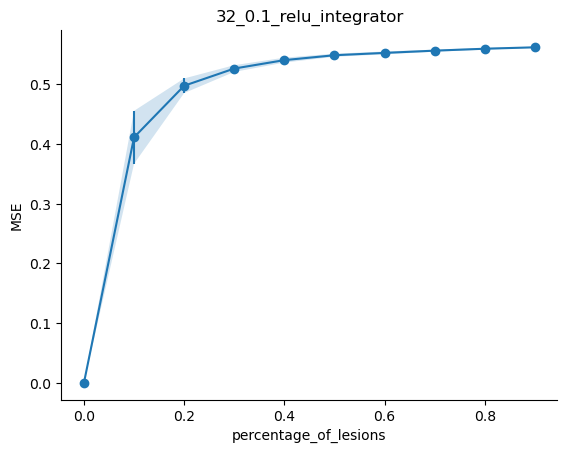

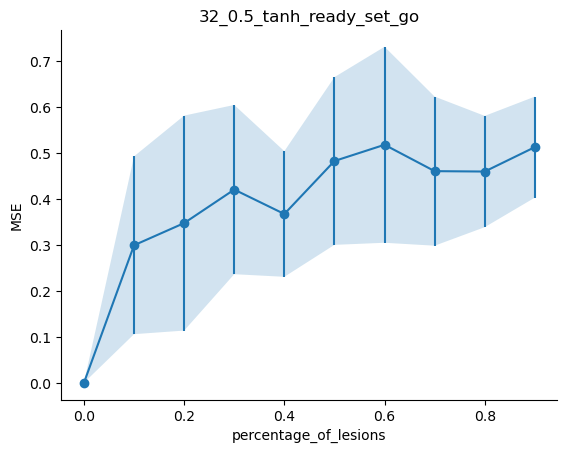

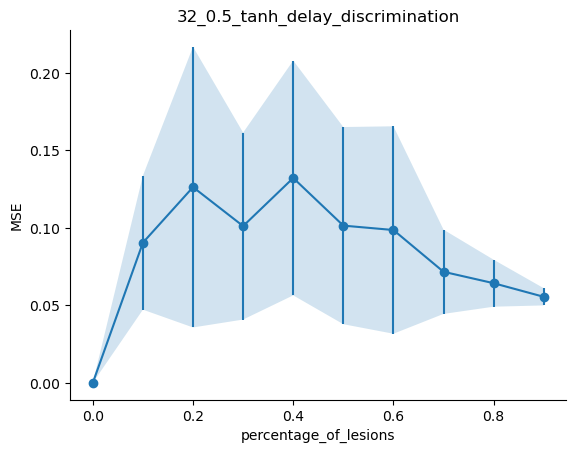

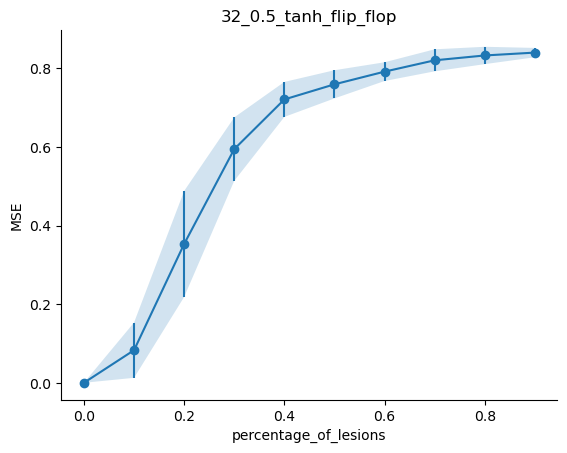

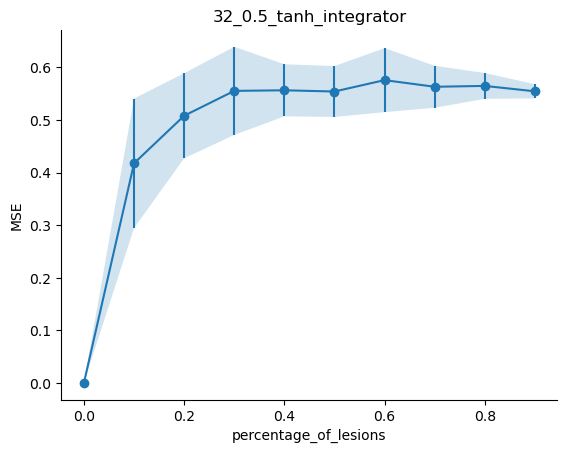

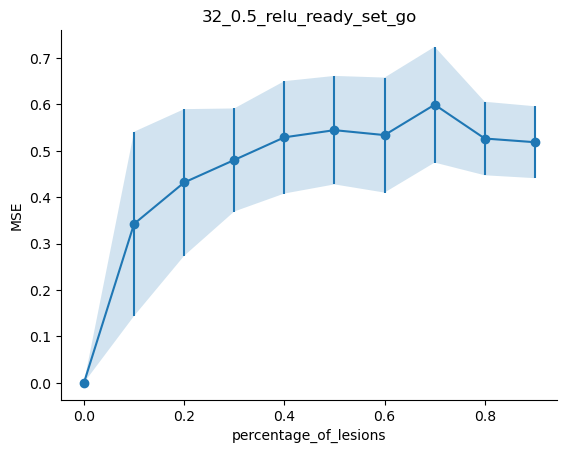

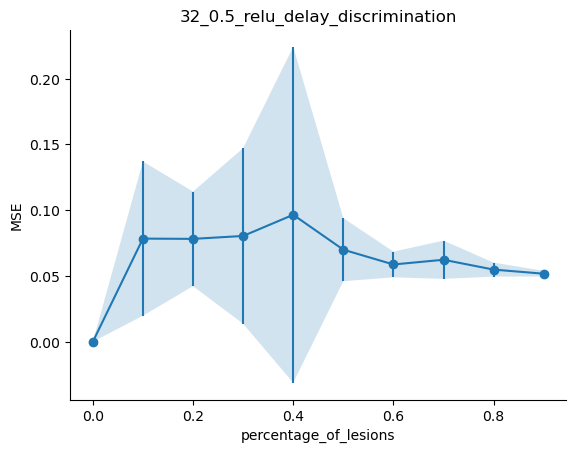

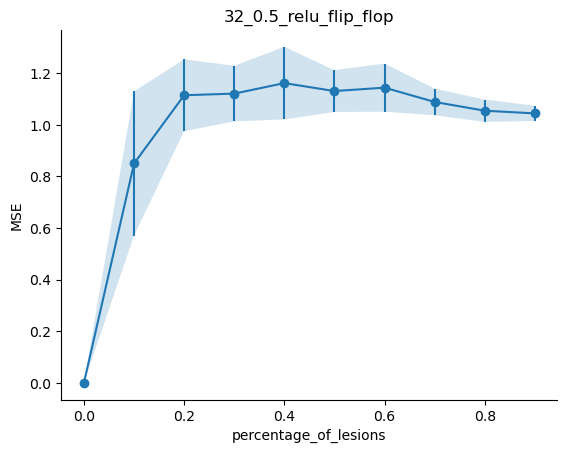

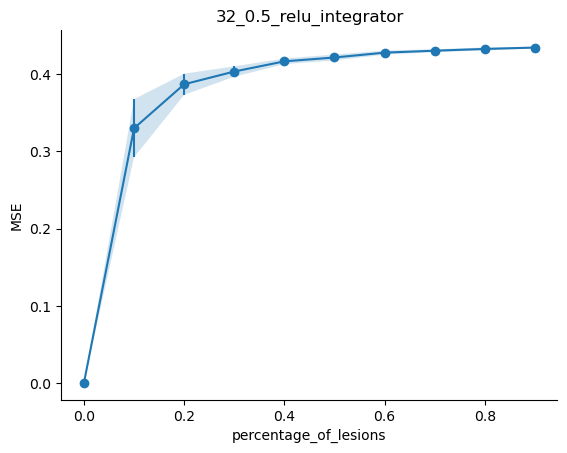

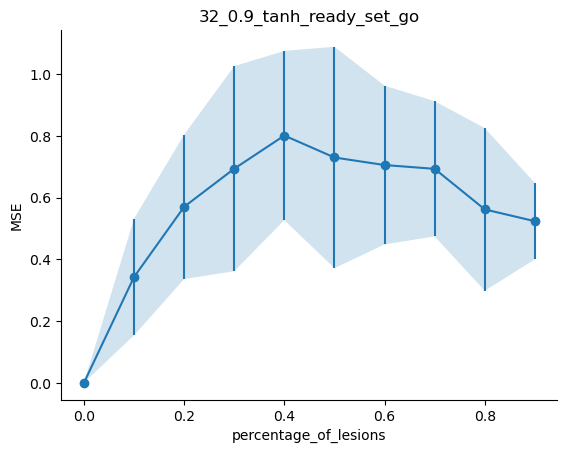

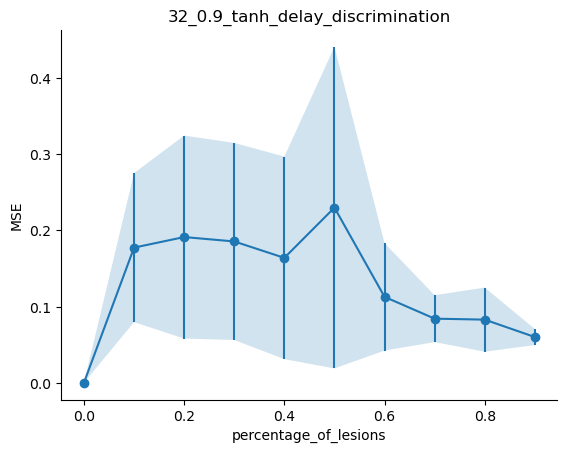

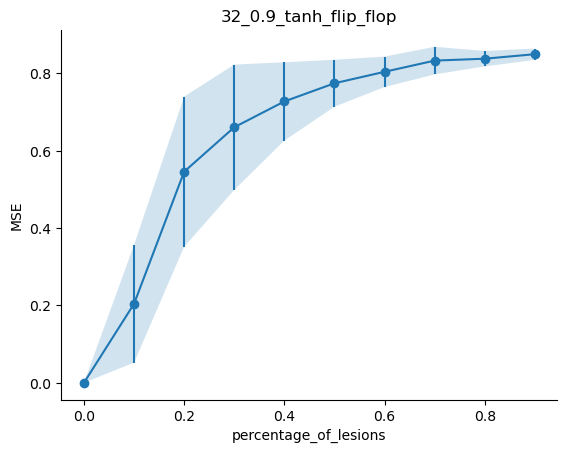

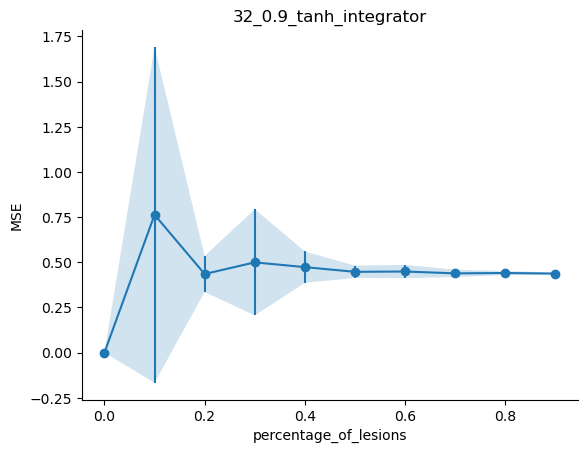

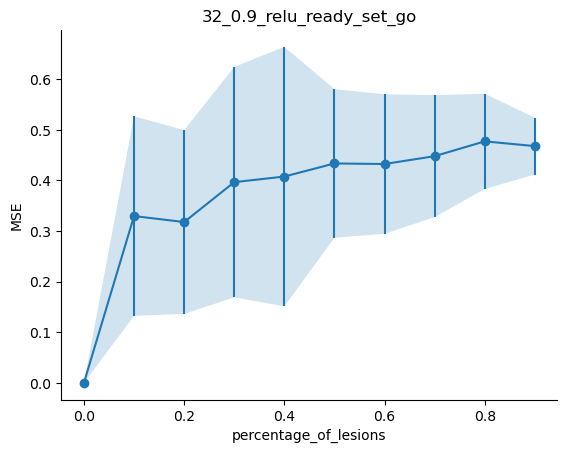

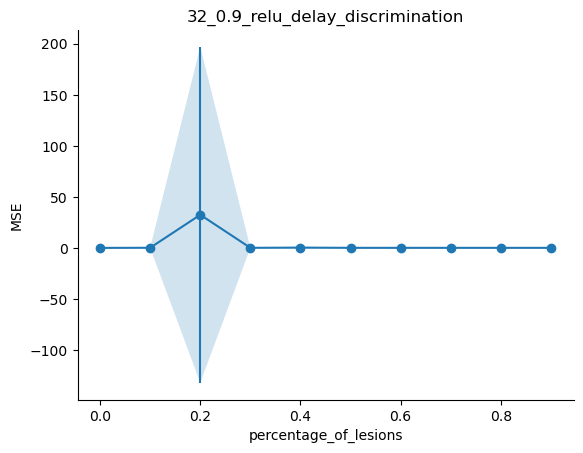

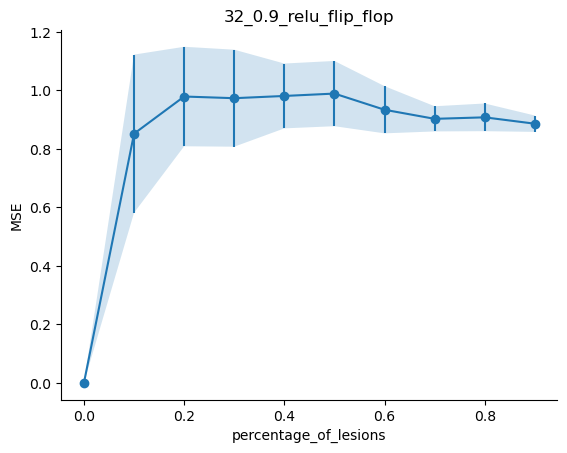

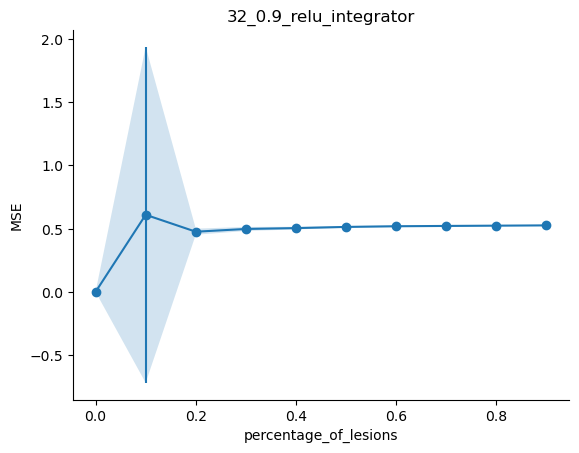

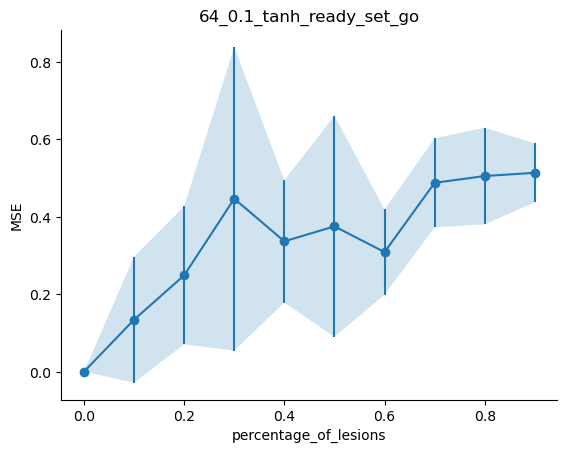

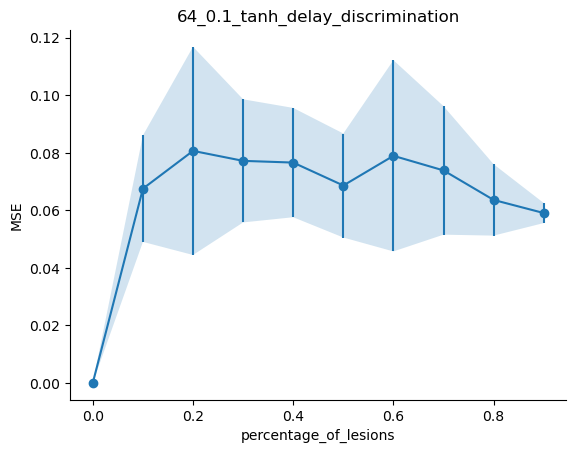

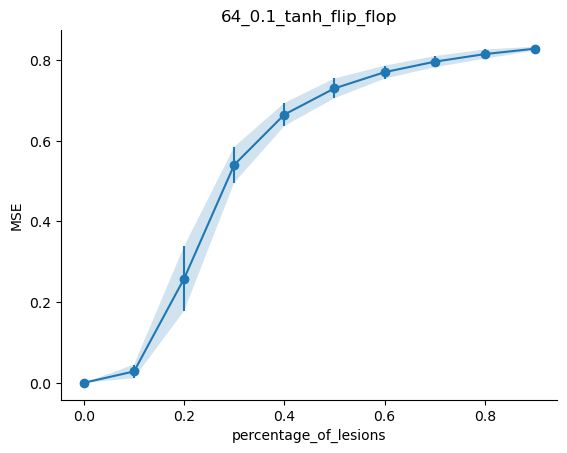

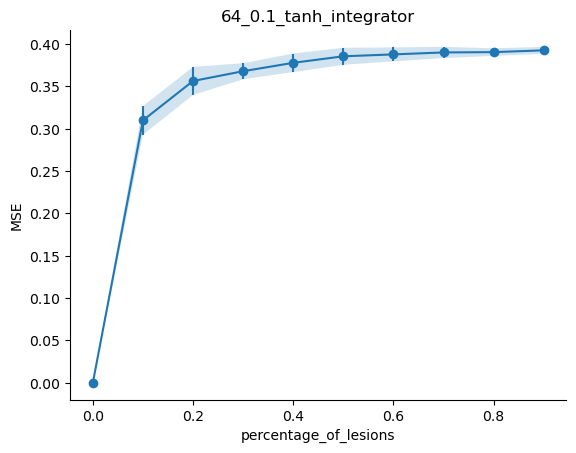

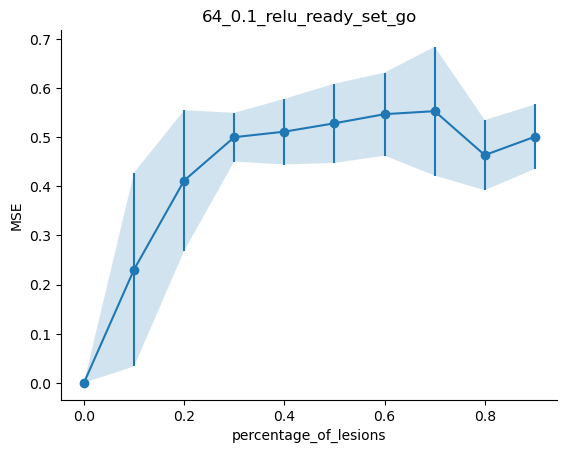

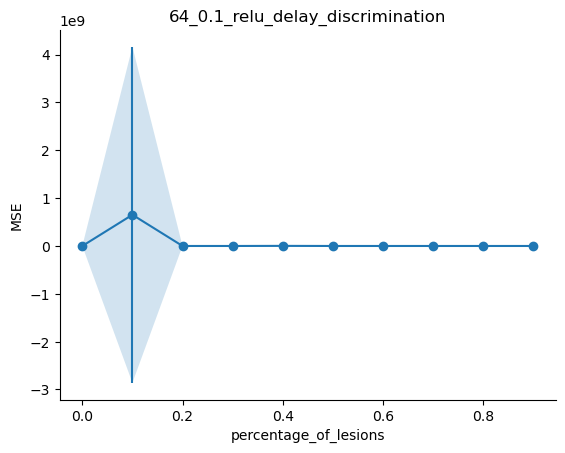

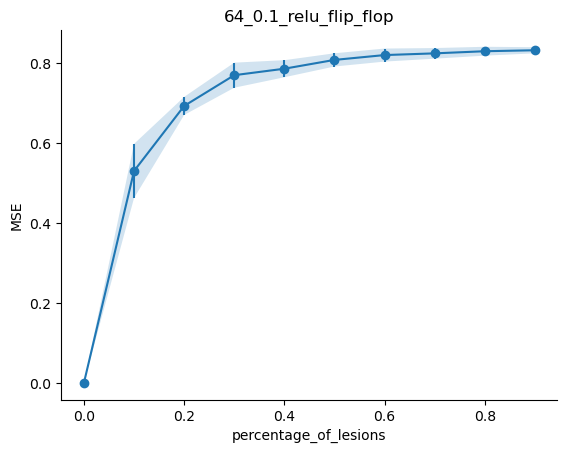

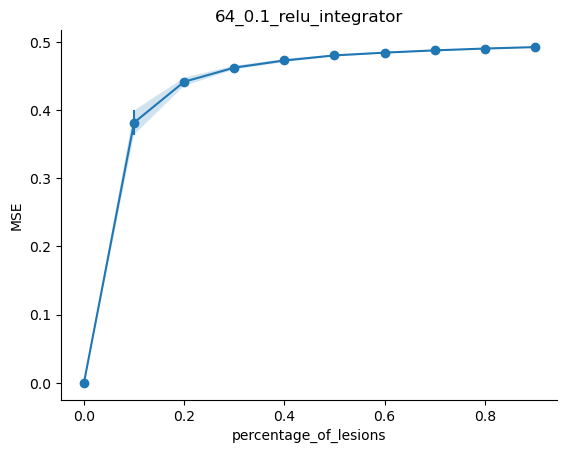

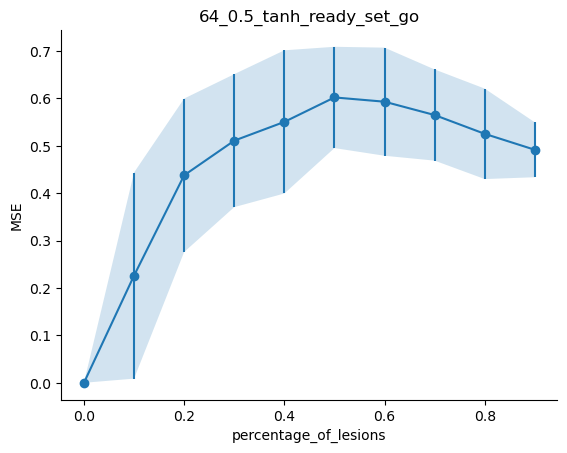

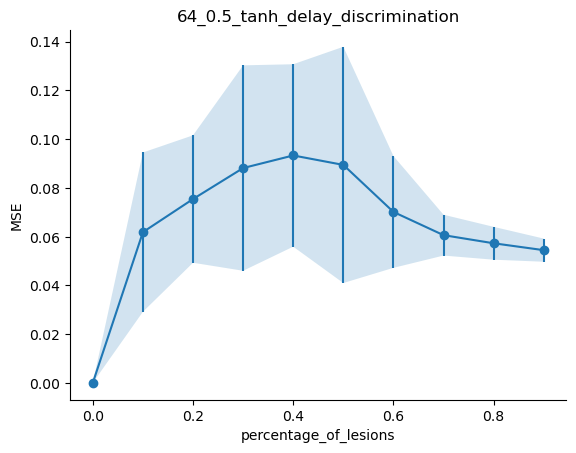

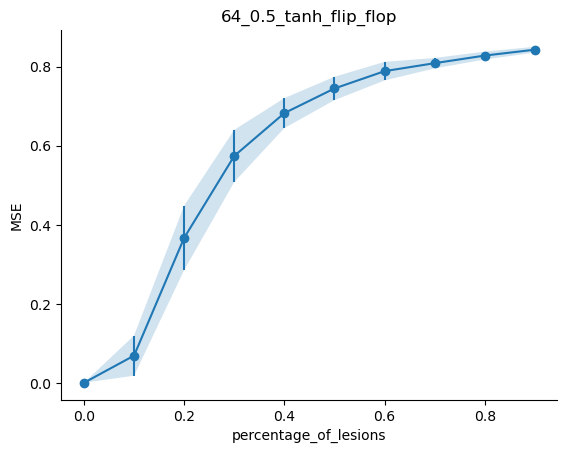

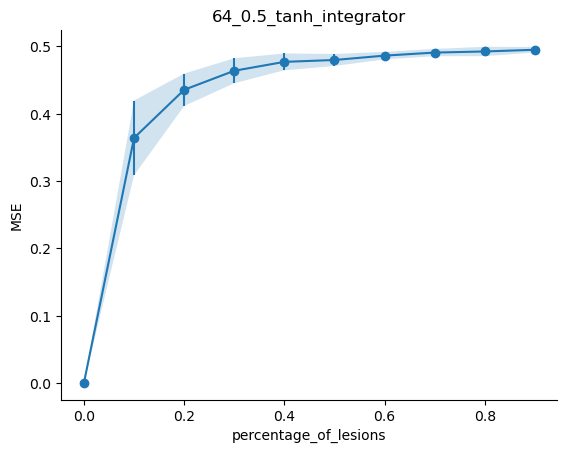

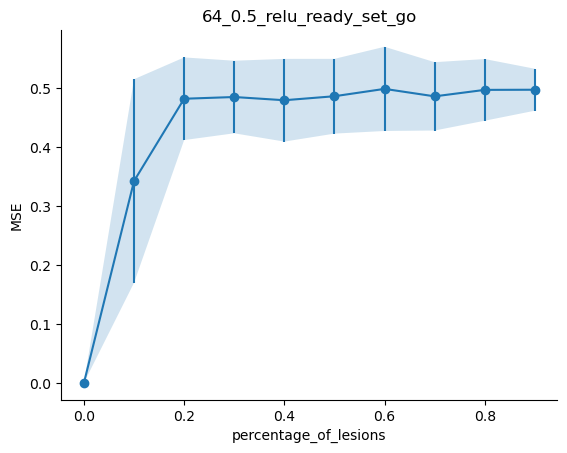

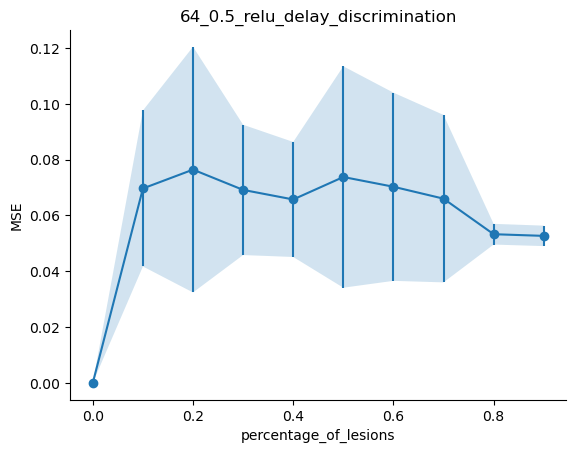

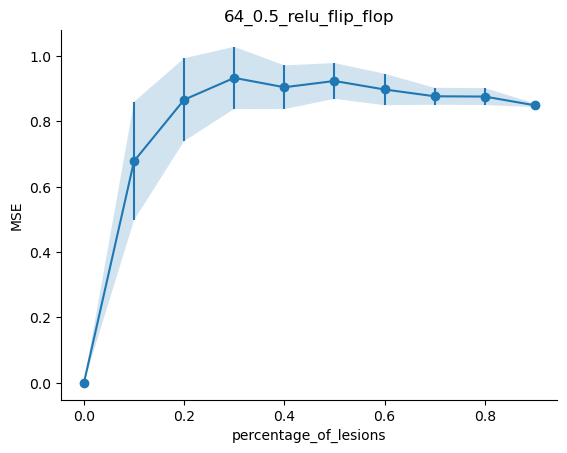

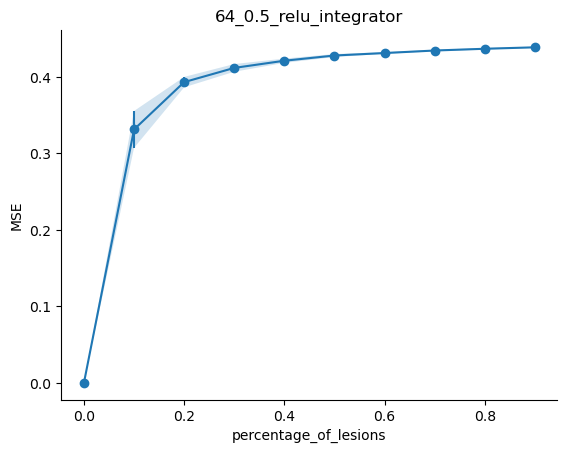

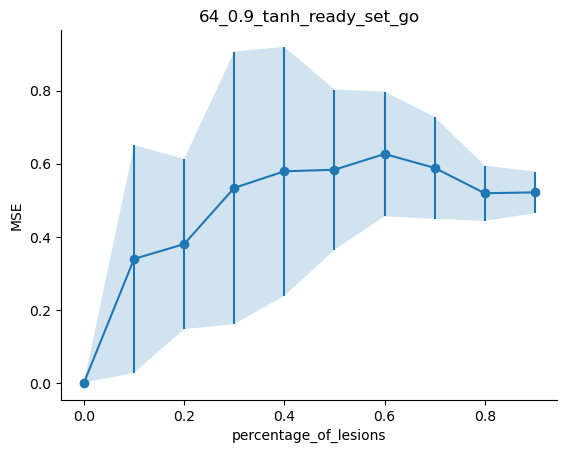

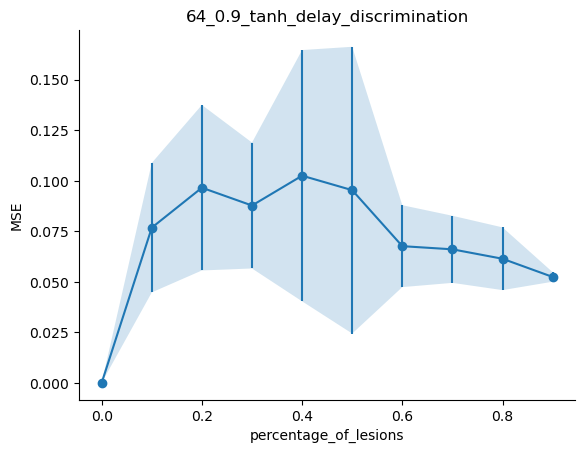

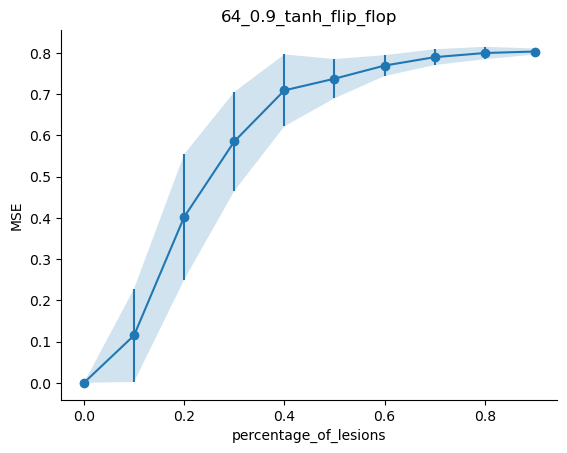

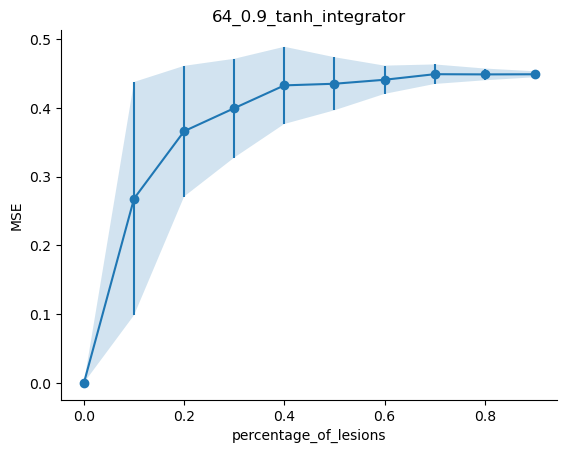

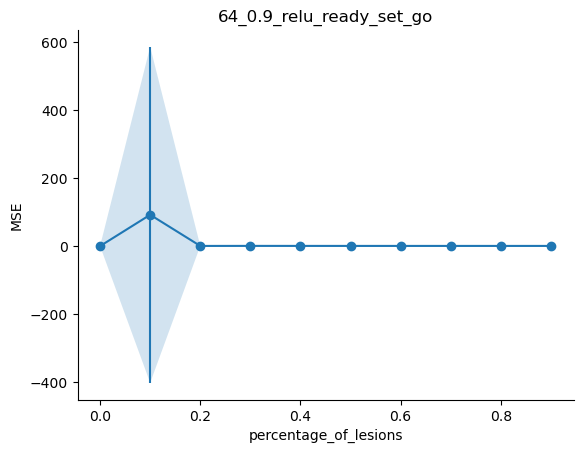

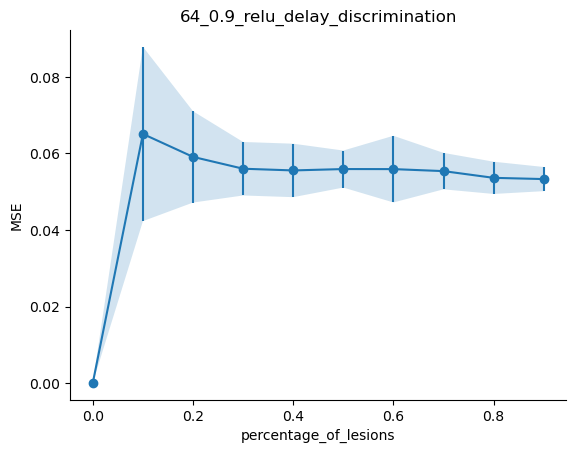

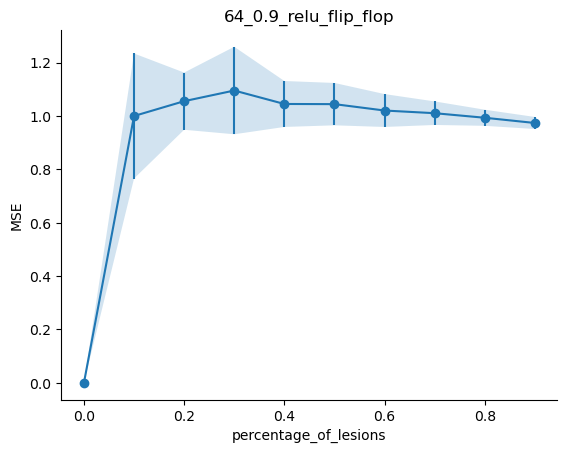

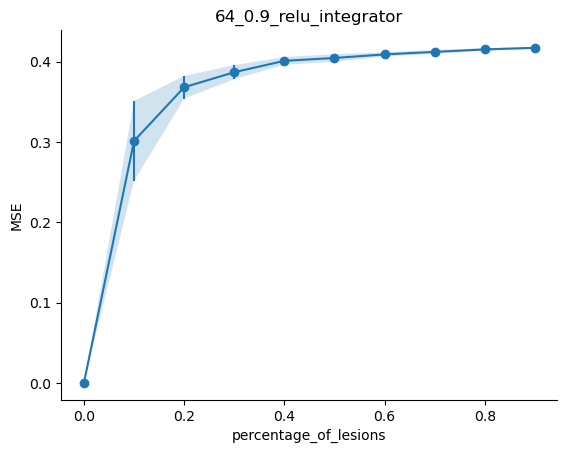

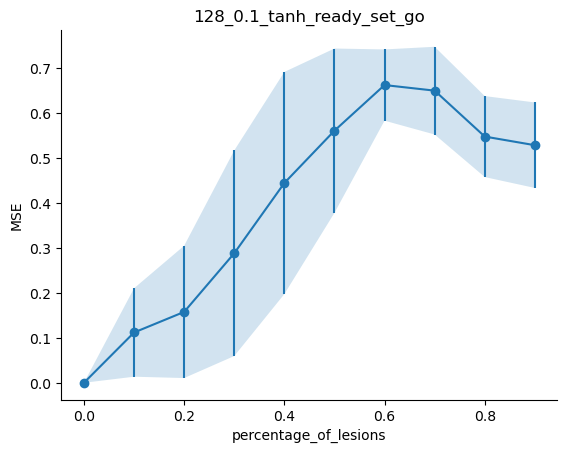

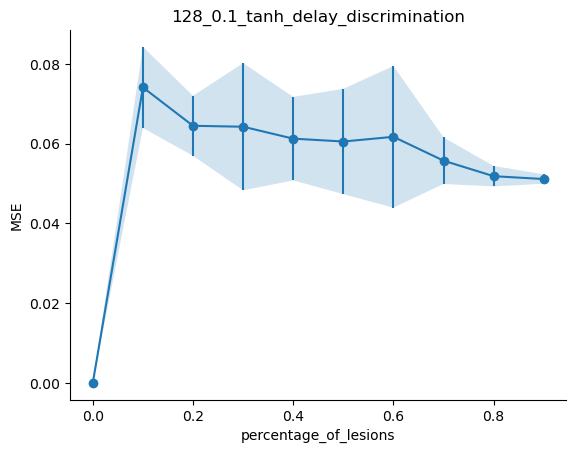

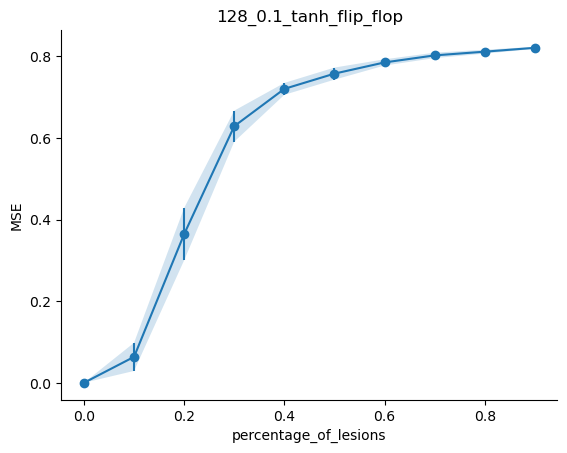

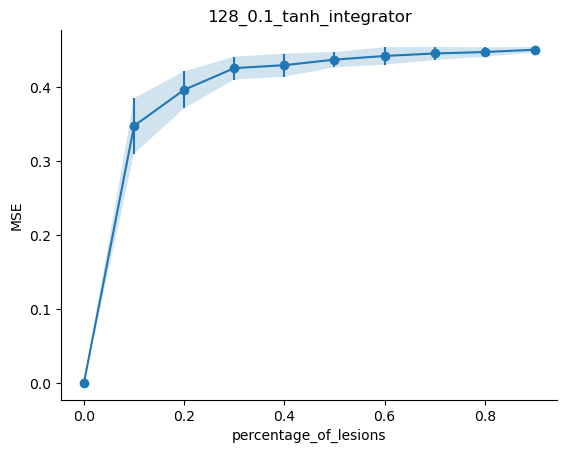

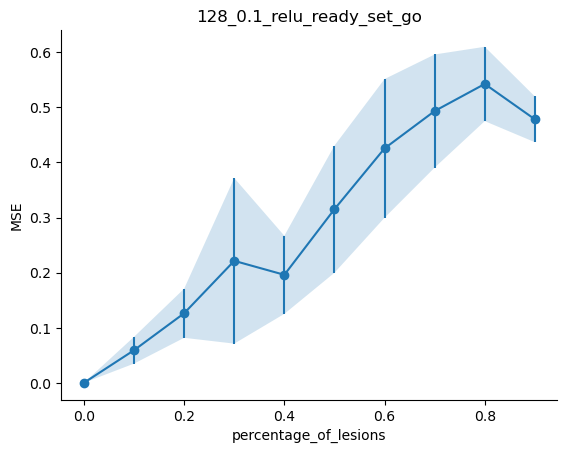

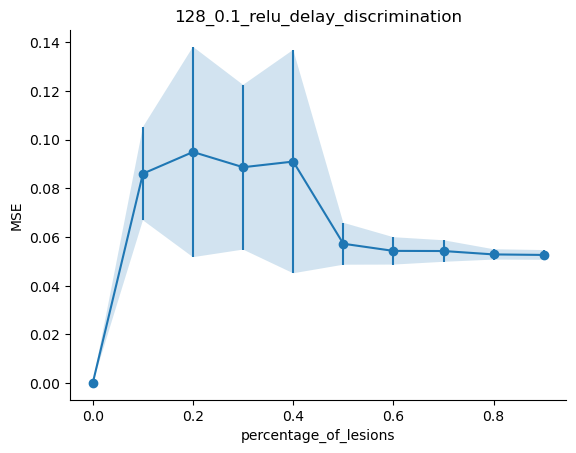

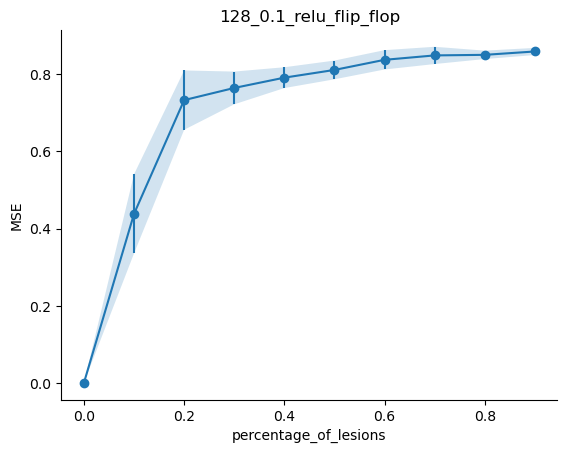

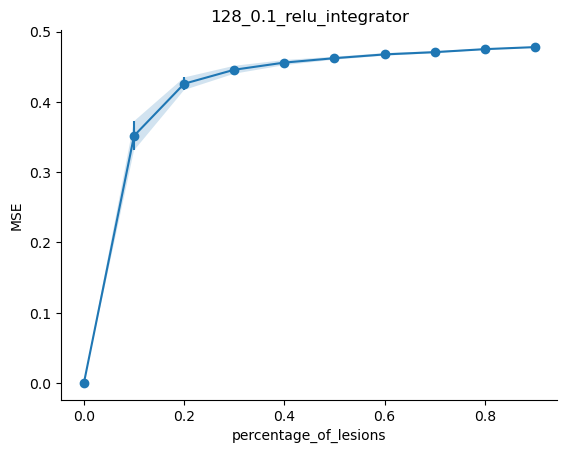

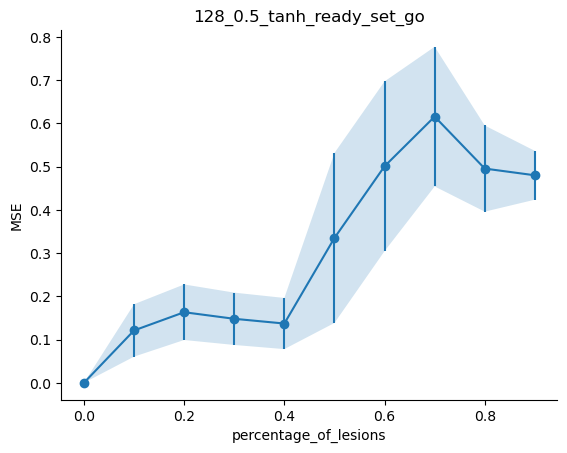

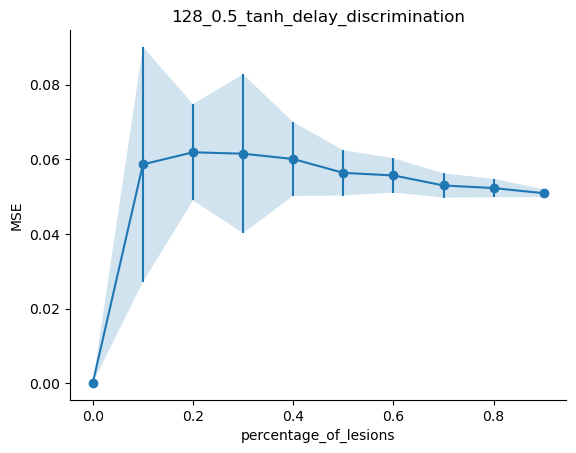

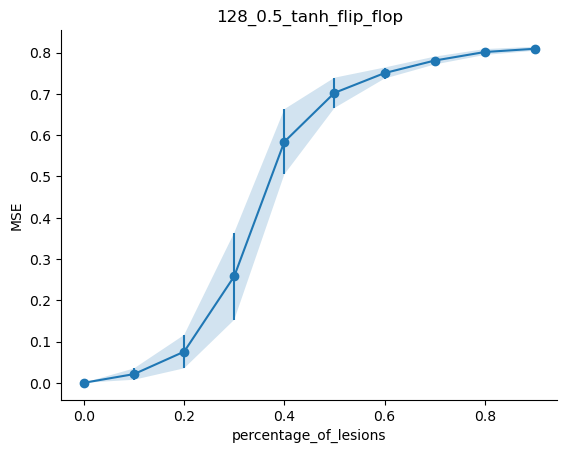

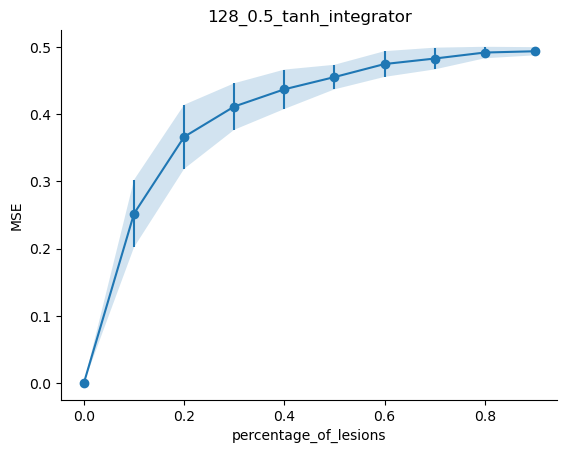

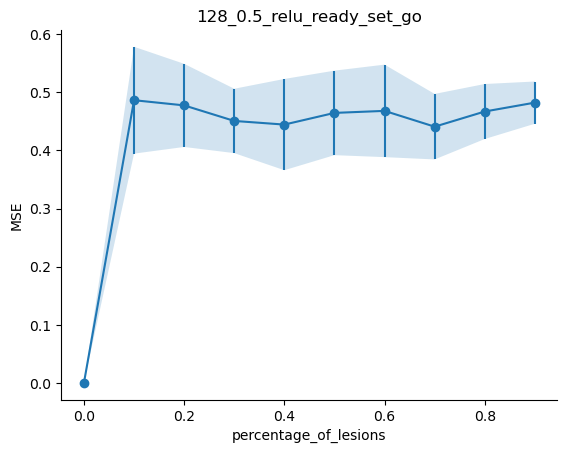

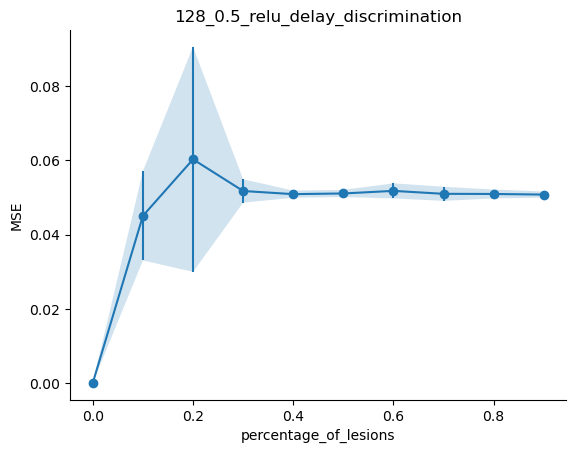

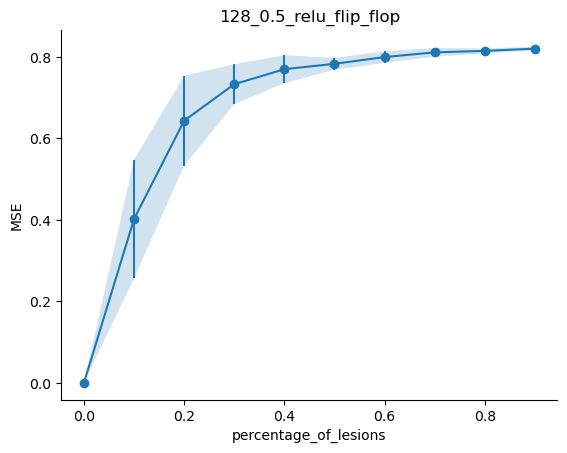

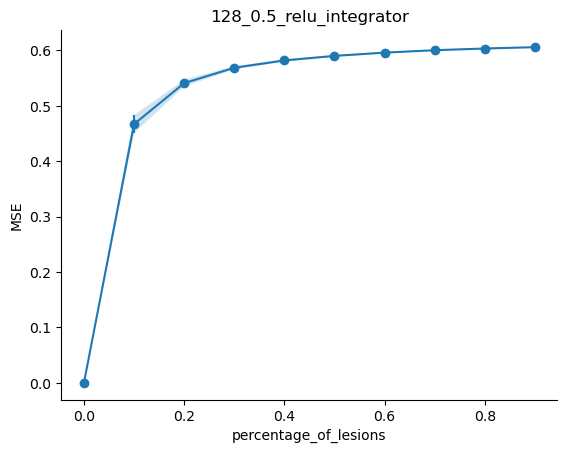

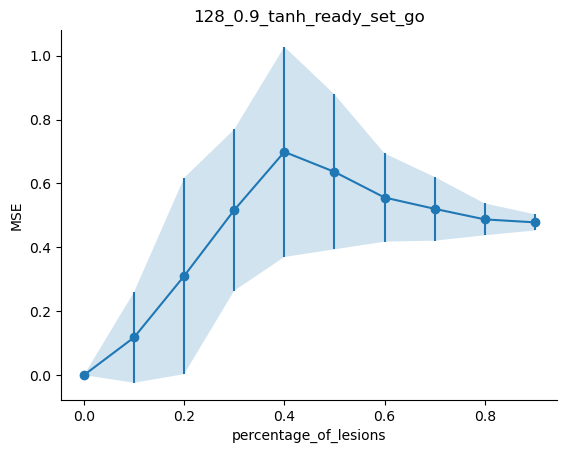

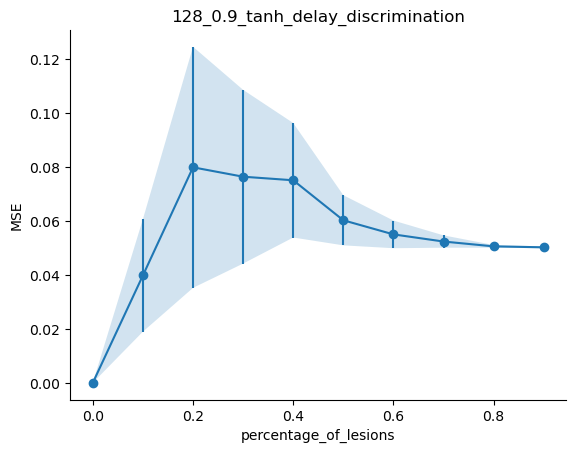

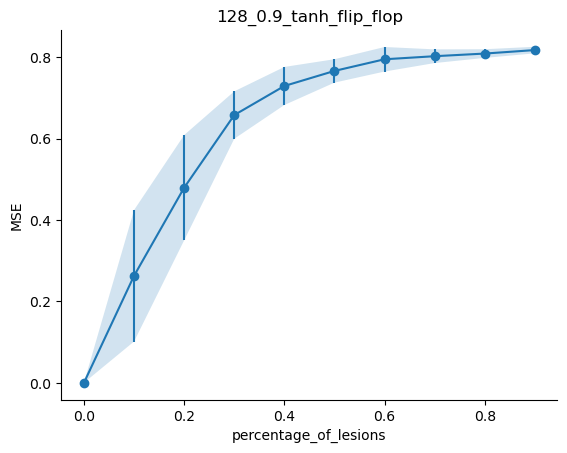

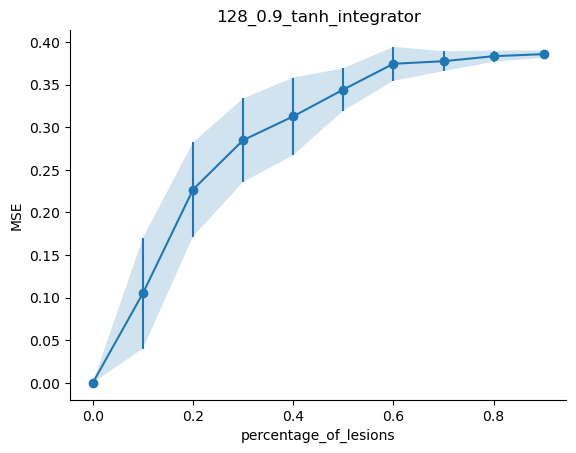

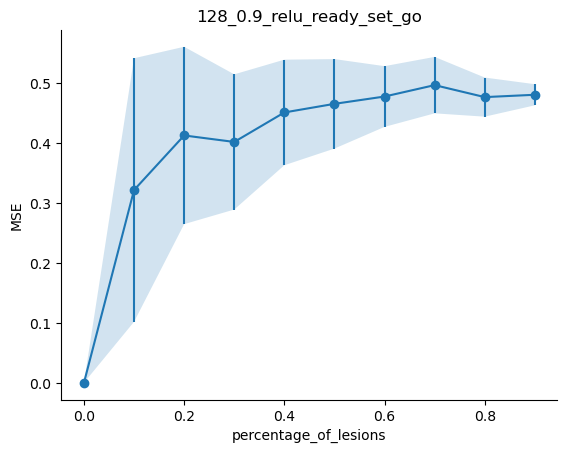

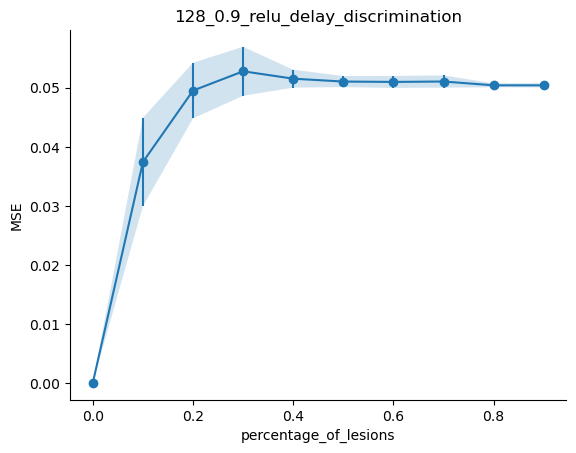

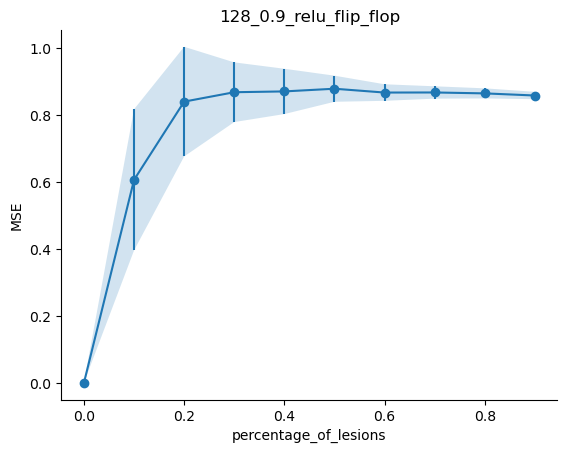

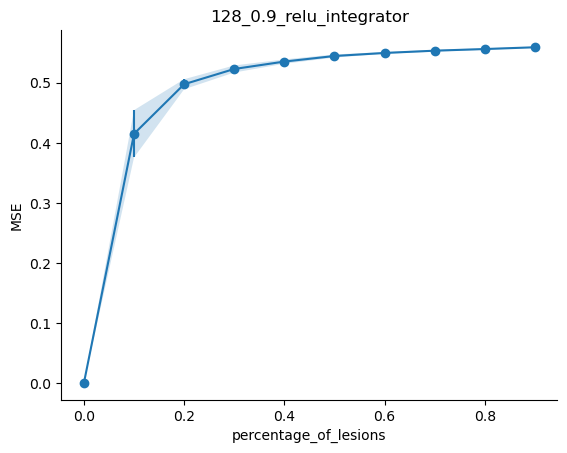

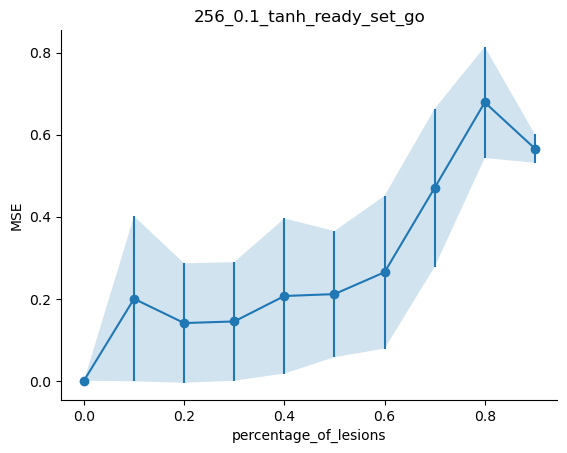

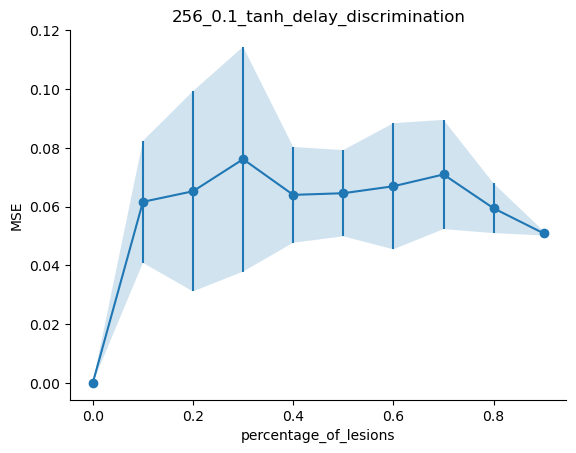

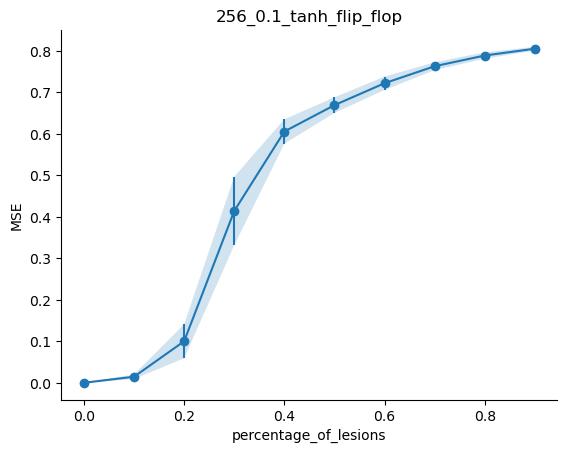

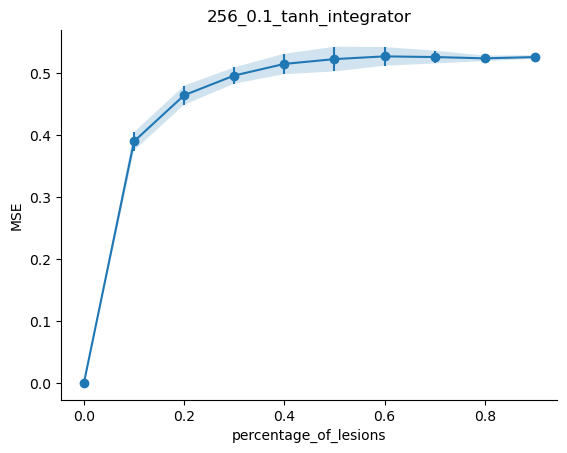

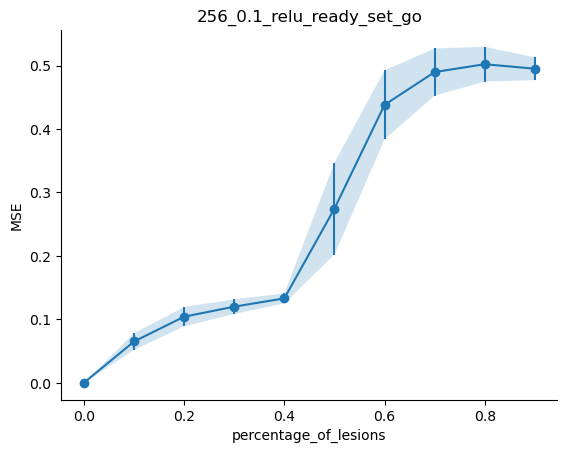

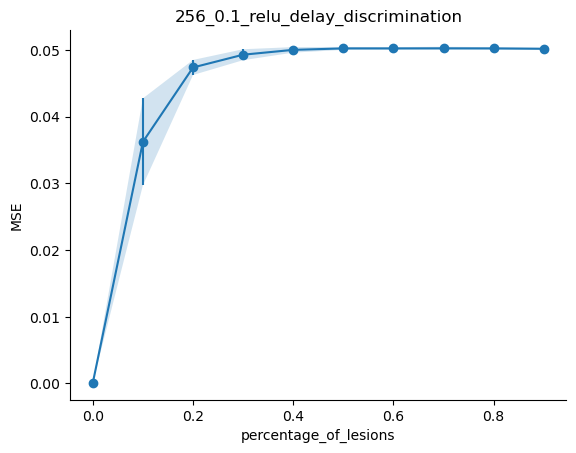

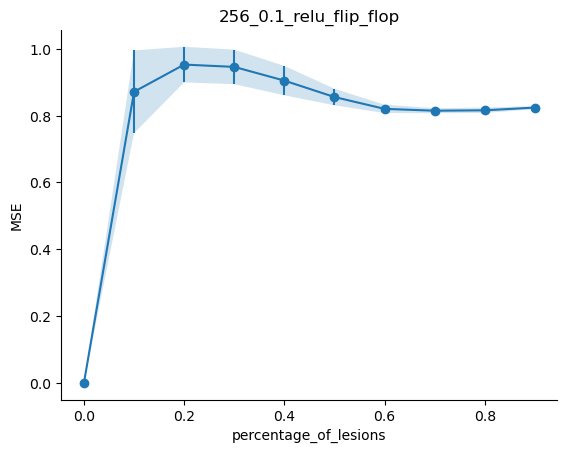

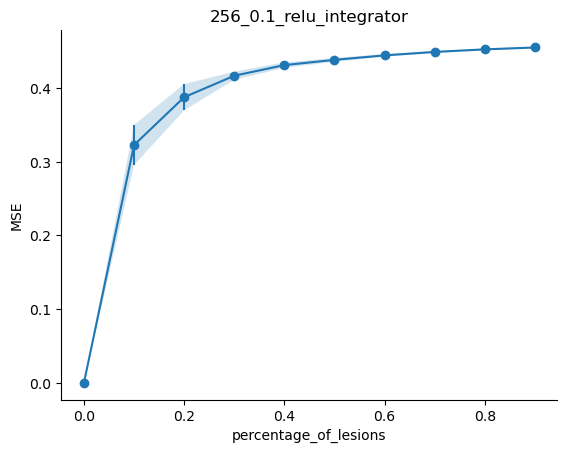

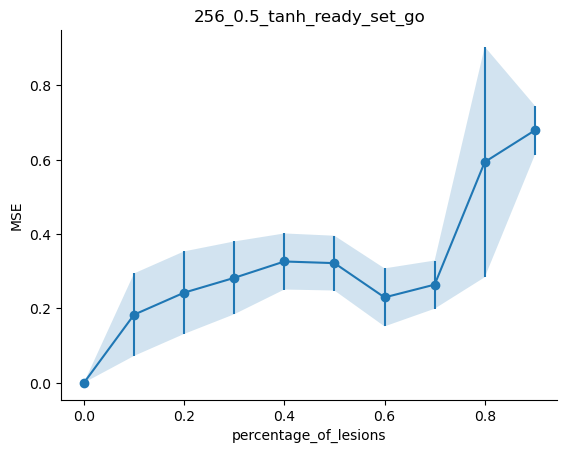

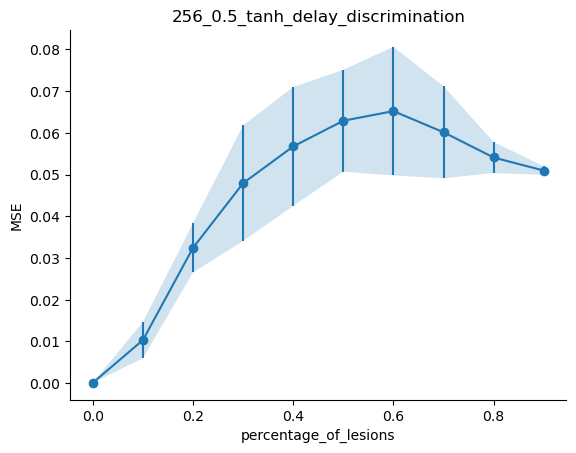

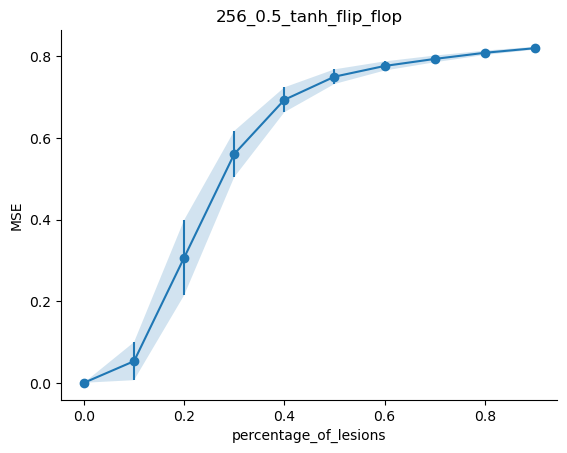

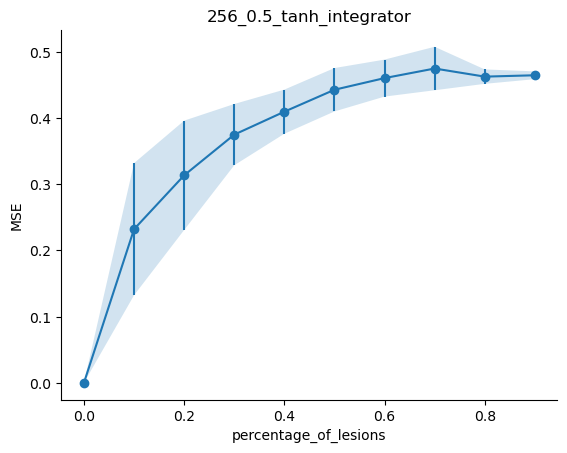

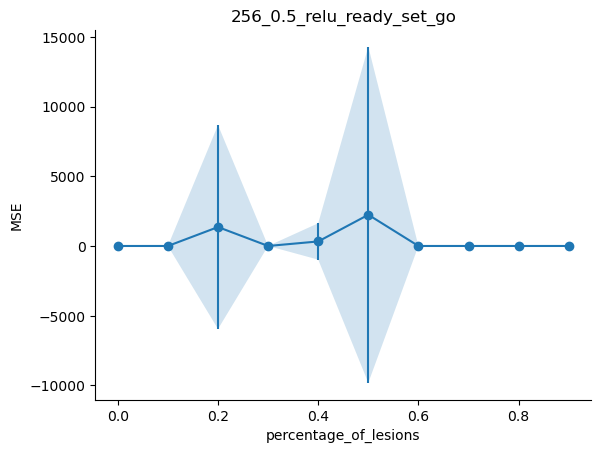

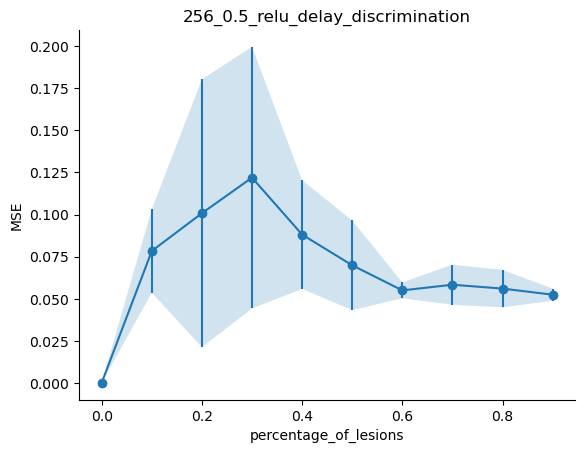

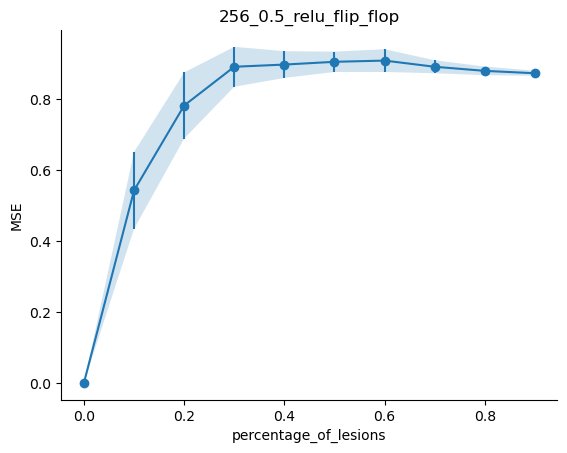

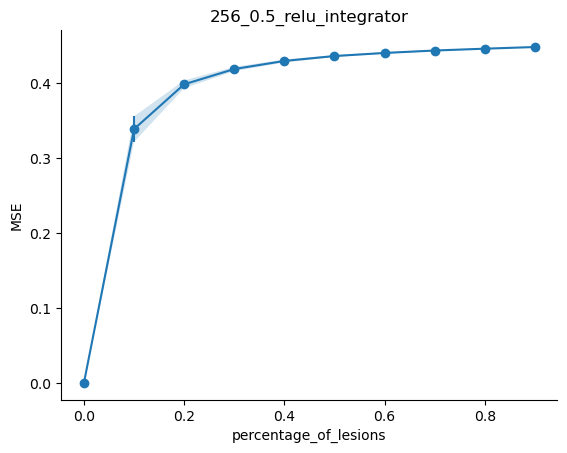

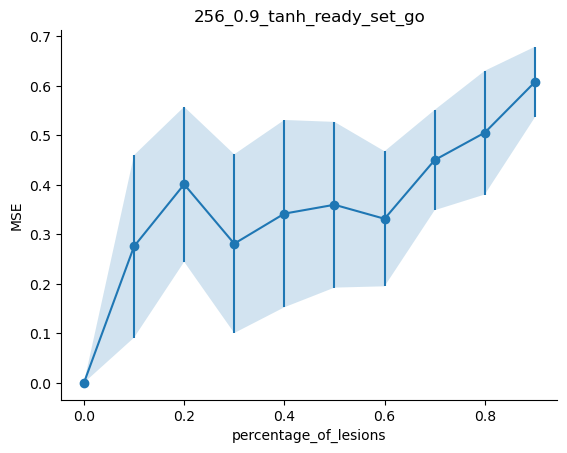

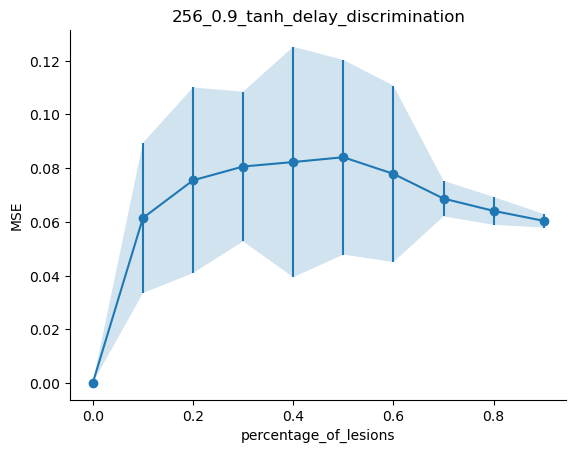

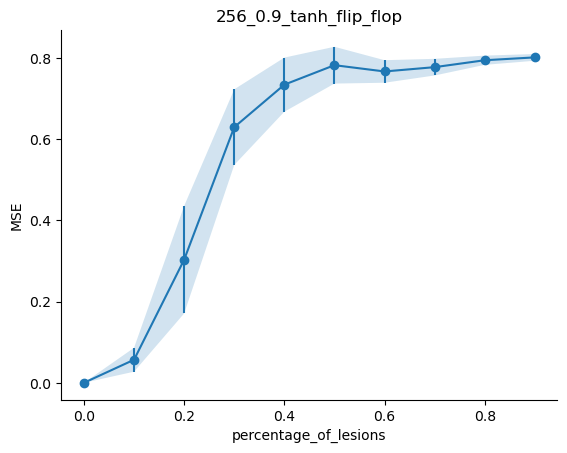

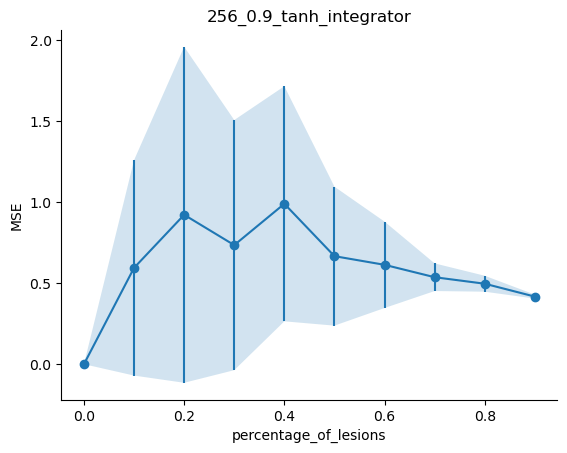

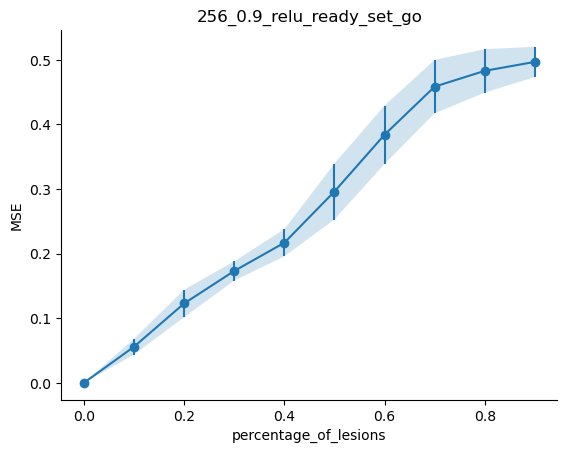

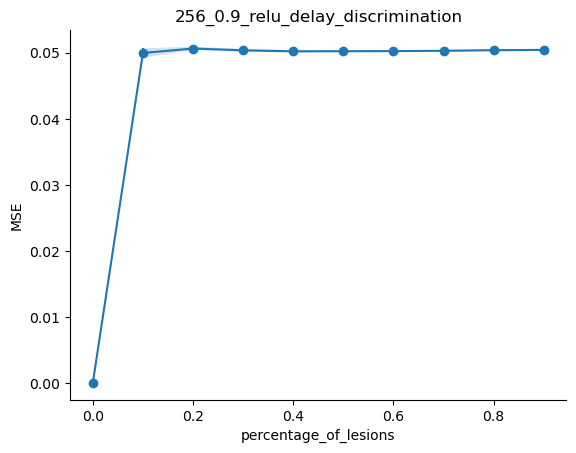

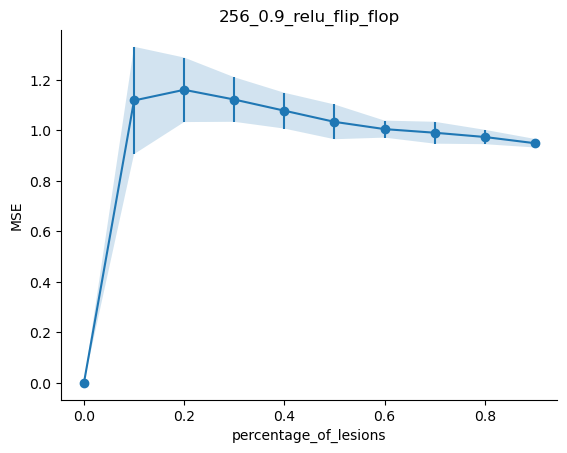

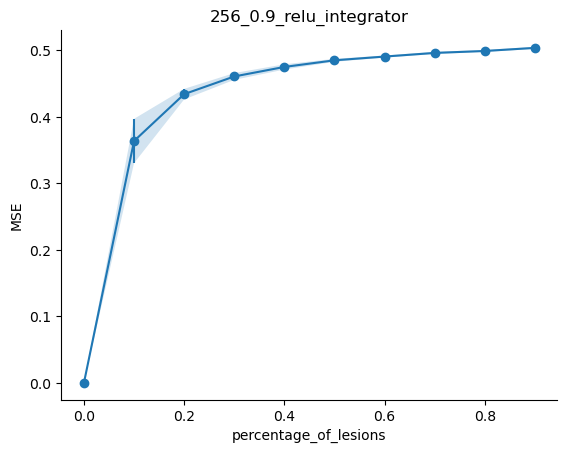

In [2]:
dic_mse = {}
for hidden_dim in hidden_dims:
        for init_type in initialization_types:
            for g in g_values:
                for nonlinearity in nonlinearities:
                    for task in tasks:
                        task_dataset = RNNTaskDataset(n_trials=100, time=100, n_channels=2)
                        x, y = getattr(task_dataset, task)()  # Get the input and target outputs for the task
                        x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
                        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
                        model = MyRNN(input_dim=x.shape[2], 
                                      hidden_dim=hidden_dim, 
                                      output_dim=y.shape[2],
                                      nonlinearity=nonlinearity, 
                                      initialize_uniform=(init_type == "uniform"),
                                      initialize_normal=(init_type == "random"), g=g).to(device)
                        
                        weights_path = os.path.join('rnn_weights_2/', f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
                        
                        # Load weights if they exist
                        if os.path.exists(weights_path):
                            model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))
                            mse = [] 
                            for i,pl in enumerate(l_percentage_of_lesions):
                                model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))
                                ac = simulate_with_lesions(model=model,X=x_tensor,y=y_tensor,percentage_of_lesions=pl,
                                                           num_of_runs=num_of_runs)
                                mse.append(ac)
                                
                            plt.title(f'{hidden_dim}_{g}_{nonlinearity}_{task}')
                            mean_mse = np.mean(mse, axis=1)
                            std_mse = np.std(mse, axis=1)
                            
                            # plt.plot(l_percentage_of_lesions,mse,'.-')
                            plt.errorbar(l_percentage_of_lesions, mean_mse,
                                         yerr=std_mse, fmt='-o', label='Mean MSE with Std Error')
                            plt.fill_between(l_percentage_of_lesions, mean_mse-std_mse, mean_mse+std_mse,alpha=0.2)
                            
                            plt.xlabel('percentage_of_lesions')
                            plt.ylabel('MSE')
                            sns.despine()
                            plt.show()
                            
                            key = f'{hidden_dim}_{g}_{nonlinearity}_{task}'
                            dic_mse[key] = mse

                        else:
                            
                            print('+++++++ NO NET +++++++:'+f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
                            weights_path = os.path.join('rnn_weights_2/', f"best_failed_weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
                            model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))
                            mse = [] 
                            for i,pl in enumerate(l_percentage_of_lesions):
                                model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))
                                ac = simulate_with_lesions(model=model,X=x_tensor,y=y_tensor,percentage_of_lesions=pl,
                                                           num_of_runs=num_of_runs)
                                mse.append(ac)
                                
                            plt.title(f'{hidden_dim}_{g}_{nonlinearity}_{task}')
                            mean_mse = np.mean(mse, axis=1)
                            std_mse = np.std(mse, axis=1)
                            
                            # plt.plot(l_percentage_of_lesions,mse,'.-')
                            plt.errorbar(l_percentage_of_lesions, mean_mse,
                                         yerr=std_mse, fmt='-o', label='Mean MSE with Std Error')
                            plt.fill_between(l_percentage_of_lesions, mean_mse-std_mse, mean_mse+std_mse)
                            
                            plt.xlabel('percentage_of_lesions')
                            plt.ylabel('MSE')
                            sns.despine()
                            plt.show()
                            
                            key = f'{hidden_dim}_{g}_{nonlinearity}_{task}'
                            dic_mse[key] = mse
                            

In [246]:
all_values = [] 
all_keys = []

for key in dic_mse.keys():
    all_values.append(np.array(dic_mse[key]).flatten())
    all_keys.append(key)

data = np.concatenate(all_values)
keys = np.repeat(np.array(all_keys),10*num_of_runs)
p_of_le = np.tile(np.repeat(np.linspace(0,.9,10),num_of_runs),96)

df = pd.DataFrame({'model':keys,
                  'lesions':p_of_le,
                   'mse':data})

data_hid = [] 
data_g_val = [] 
data_nonlinearities = [] 
data_task = [] 
for hidden_dim in hidden_dims:
    for g in g_values:
        for nonlinearity in nonlinearities:
            for task in tasks:
                TTT = len(l_percentage_of_lesions)*num_of_runs
                data_task.append(np.repeat(task,TTT))
                data_nonlinearities.append(np.repeat(nonlinearity,TTT))
                data_g_val.append(np.repeat(g,TTT))
                data_hid.append(np.repeat(hidden_dim,TTT))

data_hid = np.concatenate((data_hid))
data_g_val = np.concatenate((data_g_val))
data_nonlinearities = np.concatenate((data_nonlinearities))
data_task = np.concatenate((data_task))

df['task'] = data_task
df['non_linear'] = data_nonlinearities
df['g'] = data_g_val
df['hidden_dim'] = data_hid
df = df.drop(columns=['model'])
df = df[['task', 'hidden_dim', 'g', 'non_linear', 'lesions', 'mse']]
df = df[df['mse']<4]

In [ ]:
sns.scatterplot(x=df.lesions,y=df.mse)

In [148]:
df.to_csv('lesions_red.csv',index=False)

Text(0, 0.5, 'MSE')

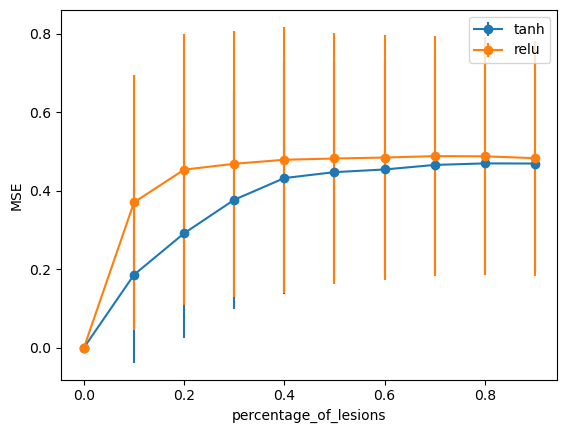

In [140]:
mean_mse = df[df.non_linear=='tanh'].groupby('lesions')['mse'].mean()
std_mse = df[df.non_linear=='tanh'].groupby('lesions')['mse'].std()
plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='tanh')
mean_mse = df[df.non_linear=='relu'].groupby('lesions')['mse'].mean()
std_mse = df[df.non_linear=='relu'].groupby('lesions')['mse'].std()
plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='relu')

plt.legend()
plt.xlabel('percentage_of_lesions')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

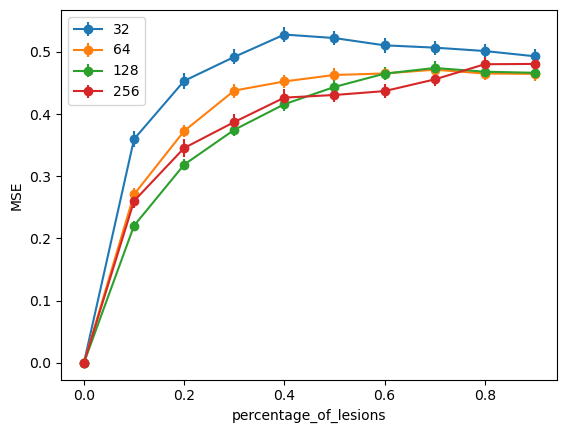

In [137]:
mean_mse = df[df.hidden_dim==32].groupby('lesions')['mse'].mean()
std_mse = df[df.hidden_dim==32].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='32')

mean_mse = df[df.hidden_dim==64].groupby('lesions')['mse'].mean()
std_mse = df[df.hidden_dim==64].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='64')

mean_mse = df[df.hidden_dim==128].groupby('lesions')['mse'].mean()
std_mse = df[df.hidden_dim==128].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='128')

mean_mse = df[df.hidden_dim==256].groupby('lesions')['mse'].mean()
std_mse = df[df.hidden_dim==256].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='256')


plt.legend()
plt.xlabel('percentage_of_lesions')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

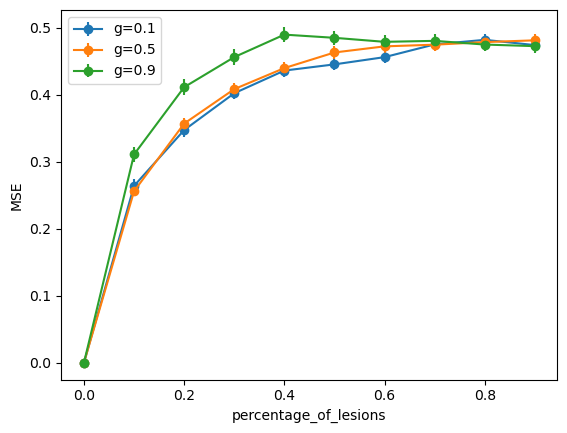

In [138]:
mean_mse = df[df.g==0.1].groupby('lesions')['mse'].mean()
std_mse = df[df.g==0.1].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='g=0.1')

mean_mse = df[df.g==0.5].groupby('lesions')['mse'].mean()
std_mse = df[df.g==0.5].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='g=0.5')

mean_mse = df[df.g==0.9].groupby('lesions')['mse'].mean()
std_mse = df[df.g==0.9].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='g=0.9')

plt.legend()
plt.xlabel('percentage_of_lesions')
plt.ylabel('MSE')

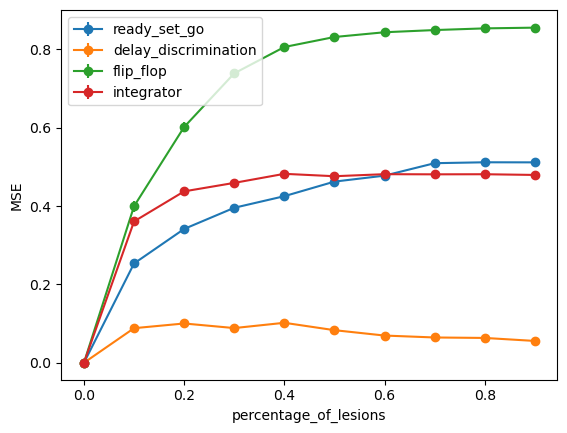

In [139]:
mean_mse = df[df.task=='ready_set_go'].groupby('lesions')['mse'].mean()
std_mse = df[df.task=='ready_set_go'].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='ready_set_go')

mean_mse = df[df.task=='delay_discrimination'].groupby('lesions')['mse'].mean()
std_mse = df[df.task=='delay_discrimination'].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='delay_discrimination')

mean_mse = df[df.task=='flip_flop'].groupby('lesions')['mse'].mean()
std_mse = df[df.task=='flip_flop'].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='flip_flop')

mean_mse = df[df.task=='integrator'].groupby('lesions')['mse'].mean()
std_mse = df[df.task=='integrator'].groupby('lesions')['mse'].sem()

plt.errorbar(l_percentage_of_lesions, mean_mse,
             yerr=std_mse, fmt='-o', label='integrator')

plt.legend()
plt.xlabel('percentage_of_lesions')
plt.ylabel('MSE')
plt.show()

loaded sucssfully
loaded sucssfully


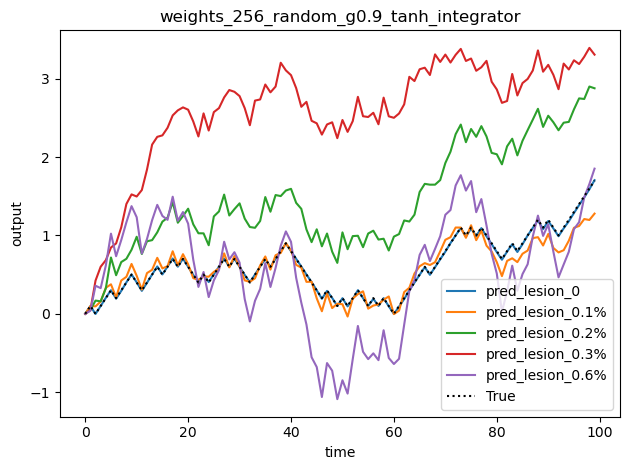

In [3]:
g=0.9
init_type = 'random'
hidden_dim = 256
nonlinearity = 'tanh' 
task = 'integrator' 

task_dataset = RNNTaskDataset(n_trials=100, time=100, n_channels=2)
x, y = getattr(task_dataset, task)()  # Get the input and target outputs for the task
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

model = MyRNN(input_dim=x.shape[2], hidden_dim=hidden_dim, output_dim=y.shape[2],nonlinearity=nonlinearity, initialize_uniform=False,
              initialize_normal=(init_type == "random"), g=g).to(device)

# weights_path = os.path.join('rnn_weights/', f"weights_{hidden_dim}_{initialization_types}_g{g}_{nonlinearity}_{task}.pt")
weights_path=f'rnn_weights_2/weights_{hidden_dim}_random_g{g}_{nonlinearity}_{task}.pt'

# Load weights if they exist
if os.path.exists(weights_path):
    print('loaded sucssfully')
    model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))

# Load weights if they exist
if os.path.exists(weights_path):
    print('loaded sucssfully')
    model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))

T = 1

if task == 'flip_flop':
    y_pred,_ = model(x_tensor[T,:])
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,4))
    ax1.plot(y_pred[:,0].squeeze().detach().numpy(),label='pred_lesion_0_c1')
    ax2.plot(y_pred[:,1].squeeze().detach().numpy(),label='pred_lesion_0_c2')

else:
    y_pred,_ = model(x_tensor[T,:])
    plt.plot(y_pred.squeeze().detach().numpy(),label='pred_lesion_0')


percentage_of_lesions = [0.1,0.2,0.3,0.6]

for per in percentage_of_lesions:
    
    model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))
    original_weights = model.rnn.weight_hh_l0.data.clone()

    num_weights = original_weights.numel()
    num_lesions = int(per * num_weights)
    
    # Randomly select indices to lesion (set to zero)
    lesion_indices = np.random.choice(num_weights, num_lesions, replace=False)
    
    # Flatten the weights to manipulate and lesion the selected indices
    flattened_weights = original_weights.view(-1)
    flattened_weights[lesion_indices] = 0
    
    # Reshape and assign lesioned weights back to the model
    model.rnn.weight_hh_l0.data = flattened_weights.view_as(original_weights)
    
    y_pred2,_ = model(x_tensor[T,:])
    if task == 'flip_flop':
        ax1.plot(y_pred2[:,0].squeeze().detach().numpy(),label=f'pred_lesion_{per}% c1')
        ax2.plot(y_pred2[:,0].squeeze().detach().numpy(),label=f'pred_lesion_{per}% c2')
    else:
        plt.plot(y_pred2.squeeze().detach().numpy(),label=f'pred_lesion_{per}%')

if task == 'flip_flop':
    ax1.plot(y_tensor[T,:,0].squeeze().detach().numpy(),color='k',alpha=1,ls=':',label='True c1')
    ax2.plot(y_tensor[T,:,1].squeeze().detach().numpy(),color='k',alpha=1,ls=':',label='True c2')
    ax1.set_ylabel('output')
    ax2.set_ylabel('output')
    ax2.set_xlabel('time')
    ax1.legend()
    ax2.legend()

else:
    plt.plot(y_tensor[T,:].squeeze().detach().numpy(),color='k',alpha=1,ls=':',label='True')
    plt.ylabel('output')
    plt.xlabel('time')
    plt.legend()
    
plt.title(f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}")



plt.tight_layout()
plt.savefig('fig.pdf')
plt.show()

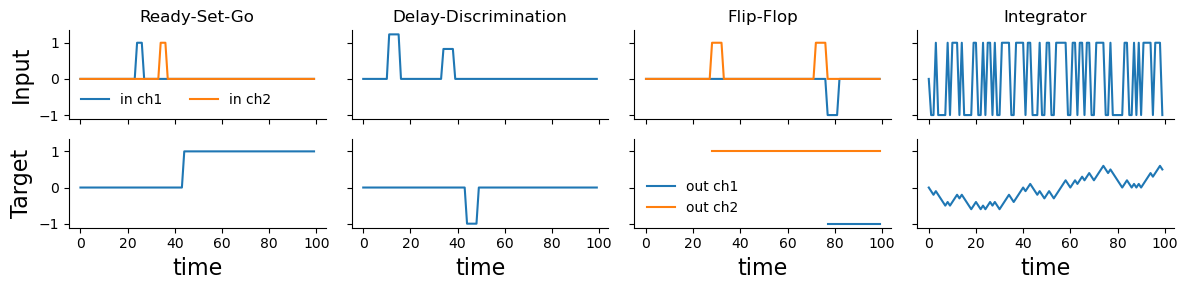

In [228]:
tasks = ['ready_set_go', 'delay_discrimination', 'flip_flop', 'integrator']

task_name = ['Ready-Set-Go', 'Delay-Discrimination', 'Flip-Flop', 'Integrator']
fig,ax = plt.subplots(2,4,sharex=True,sharey=True,figsize=(12,3))
for i,task in enumerate(tasks):
    task_dataset = RNNTaskDataset(n_trials=1, time=100, n_channels=2)
    x, y = getattr(task_dataset, task)()  # Get the input and target outputs for the task

    ax[0,i].set_title(task_name[i])

    ax[1,i].set_xlabel('time',size=16)

    ax[0,0].set_ylabel('Input',size=16)
    ax[1,0].set_ylabel('Target',size=16)
    
    if x.shape[2]==2:
        ax[0,i].plot(x[:,:,0].flatten(),label='in ch1')
        ax[0,i].plot(x[:,:,1].flatten(),label='in ch2')
        if i==0:
            ax[0,i].legend(frameon=False,loc='best',ncol=2)
    else:
        ax[0,i].plot(x.flatten())
        
    if y.shape[2]==2:
        ax[1,i].plot(y[:,:,0].flatten(),label='out ch1')
        ax[1,i].plot(y[:,:,1].flatten(),label='out ch2')
        ax[1,i].legend(frameon=False)
    else:
        ax[1,i].plot(y.flatten())

    ax[1,i].tick_params(axis='both',labelsize=10)

    

plt.tight_layout()
sns.despine()
plt.savefig('task.pdf')
plt.show()

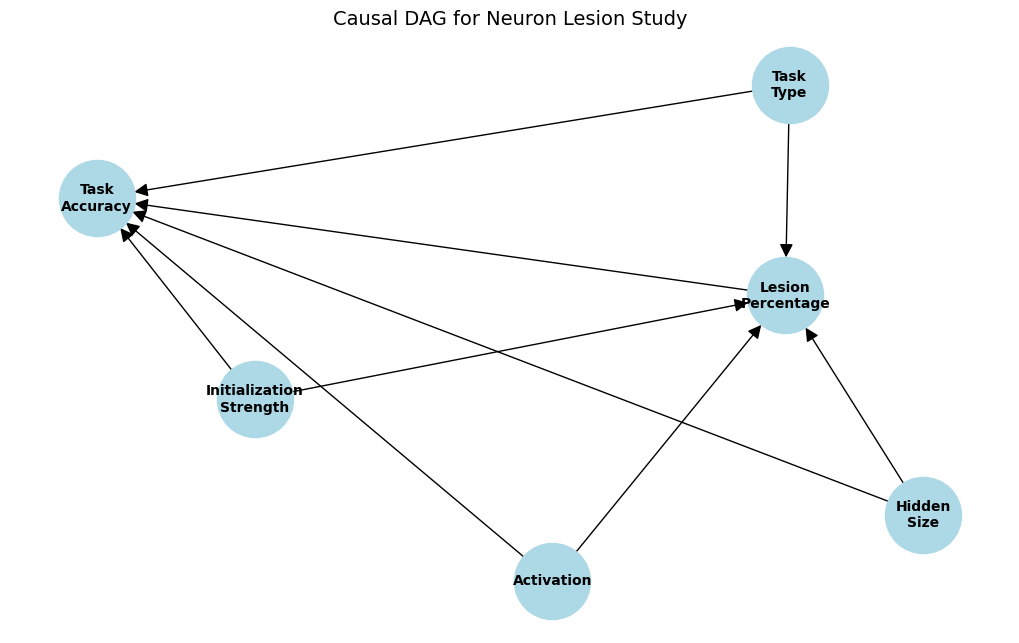

In [259]:
# Re-attempting to create the DAG using matplotlib without downloading the file.
import matplotlib.pyplot as plt
import networkx as nx

# Create a Directed Acyclic Graph (DAG)
G = nx.DiGraph()

# Add nodes (variables)
G.add_nodes_from([
    "Task\nType", "Hidden\nSize", "Activation", "Initialization\nStrength", 
    "Lesion\nPercentage", "Task\nAccuracy"
])

# Add edges (dependencies and confounding relationships)
# Task configuration affects both Lesion Percentage and Task Accuracy
G.add_edges_from([
    ("Task\nType", "Lesion\nPercentage"),
    ("Task\nType", "Task\nAccuracy"),
    ("Hidden\nSize", "Lesion\nPercentage"),
    ("Hidden\nSize", "Task\nAccuracy"),
    ("Activation", "Lesion\nPercentage"),
    ("Activation", "Task\nAccuracy"),
    ("Initialization\nStrength", "Lesion\nPercentage"),
    ("Initialization\nStrength", "Task\nAccuracy"),
    
    # Lesion percentage directly affects Task Accuracy
    ("Lesion\nPercentage", "Task\nAccuracy")
])

# Plot the DAG
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Layout for the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold', arrowsize=20)
plt.title("Causal DAG for Neuron Lesion Study", fontsize=14)
plt.show()


In [ ]:
hidden_dim = 64
nonlinearity='relu'
task = 'delay_discrimination'

task_dataset = RNNTaskDataset(n_trials=100, time=100, n_channels=2)
x, y = getattr(task_dataset, task)()  # Get the input and target outputs for the task
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

 model = MyRNN(input_dim=x_tensor.shape[2], hidden_dim=hidden_dim, output_dim=y_tensor.shape[2],nonlinearity=nonlinearity, initialize_uniform=False,
                  initialize_normal=(init_type == "random"), g=g).to(device)
    weights_path = os.path.join('rnn_weights_2/', f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
    model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))


for g in [0.1,0.5,0.9]:
    
    model = MyRNN(input_dim=x_tensor.shape[2], hidden_dim=hidden_dim, output_dim=y_tensor.shape[2],nonlinearity=nonlinearity, initialize_uniform=False,
                  initialize_normal=(init_type == "random"), g=g).to(device)
    weights_path = os.path.join('rnn_weights_2/', f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
    model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))
    print(torch.linalg.norm(model.rnn.weight_hh_l0))
    
    o,h = model(x_tensor)
    sns.histplot(h.detach().numpy().mean(axis=1).squeeze(),label=f'g={g}')
    
plt.legend()
plt.show()


def plot_ev_spectra(W):
    
    eigenvalues = np.linalg.eigvals(W)
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    theta = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), 'r--')  # Unit circle
    ax.axvline(1, ls='--', c='grey', zorder=-1, alpha=0.5)
    ax.scatter(eigenvalues.real, eigenvalues.imag, color='blue')
    ax.axhline(0, color='black', lw=1)
    ax.axvline(0, color='black', lw=1)
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    plt.axis('equal')
    plt.tight_layout()
    sns.despine()
    plt.show()

# plot_ev_spectra(model.state_dict()['rnn.weight_hh_l0'].detach().numpy())

In [759]:
hidden_dim = 256
nonlinearity='tanh'
task = 'integrator'

task_dataset = RNNTaskDataset(n_trials=100, time=100, n_channels=2)
x, y = getattr(task_dataset, task)()  # Get the input and target outputs for the task
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

model = MyRNN(input_dim=x_tensor.shape[2], hidden_dim=hidden_dim, output_dim=y_tensor.shape[2],nonlinearity=nonlinearity, initialize_uniform=False,
              initialize_normal=(init_type == "random"), g=g).to(device)
weights_path = os.path.join('rnn_weights_2/', f"weights_{hidden_dim}_{init_type}_g{g}_{nonlinearity}_{task}.pt")
model.load_state_dict(torch.load(weights_path,map_location=torch.device('cpu')))

<All keys matched successfully>

<Axes: ylabel='Count'>

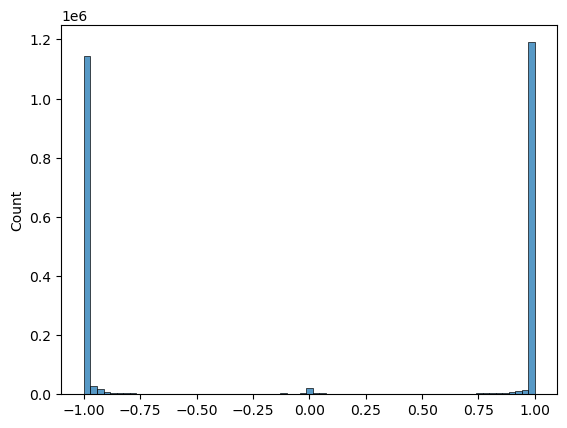

In [761]:
sns.histplot(torch.stack(all_hidden).detach().numpy().squeeze().flatten())

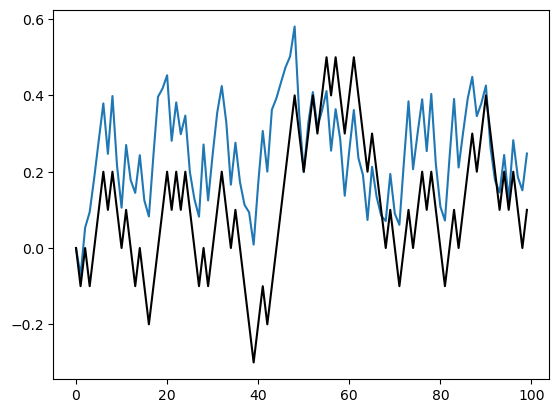

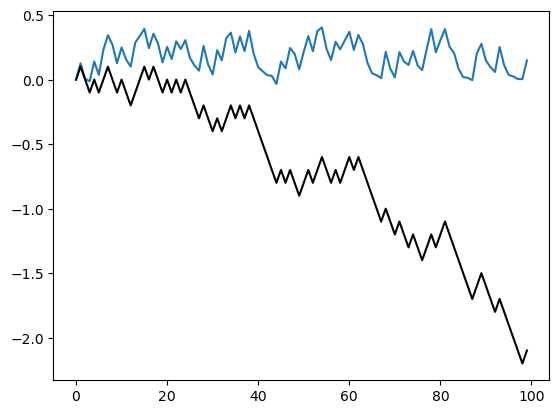

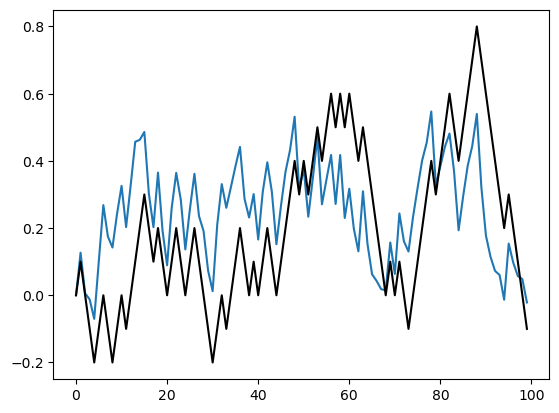

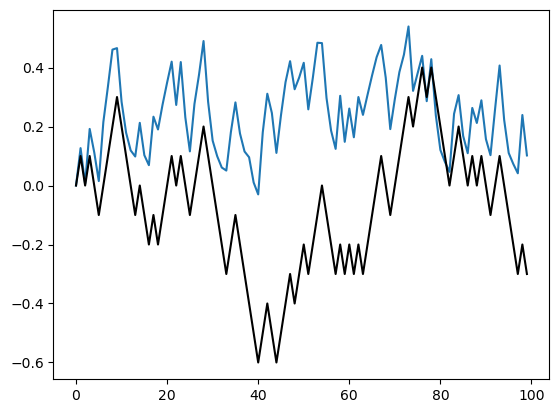

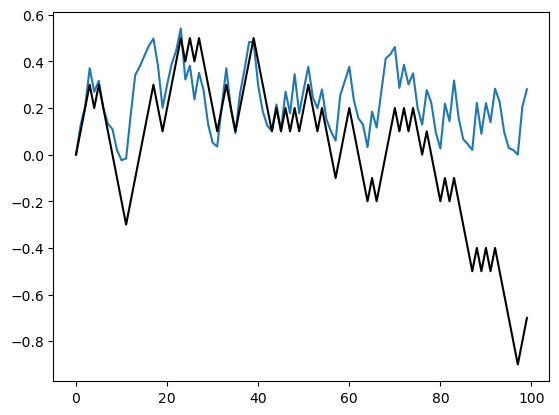

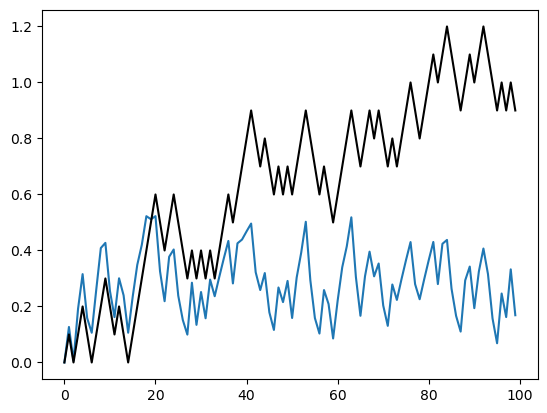

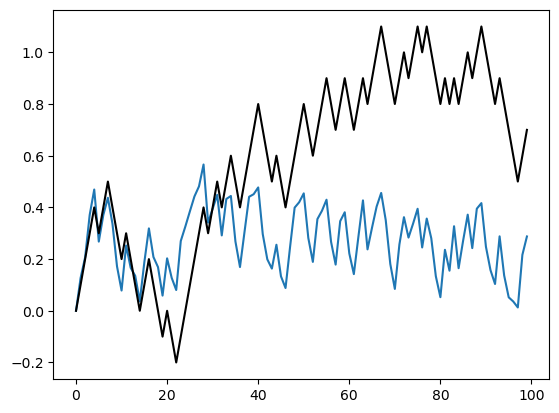

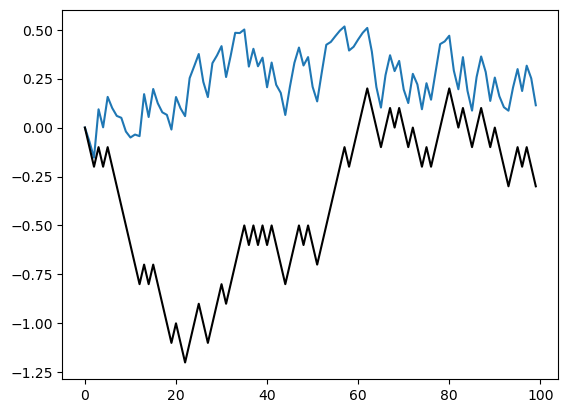

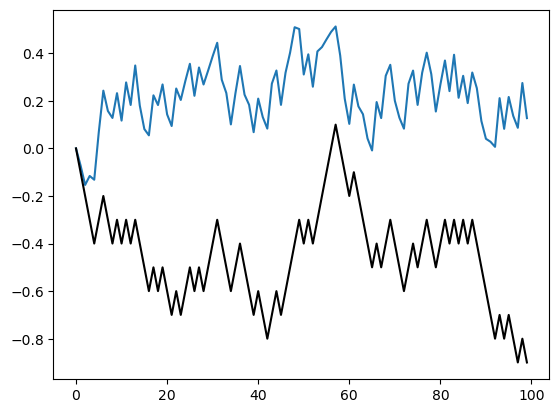

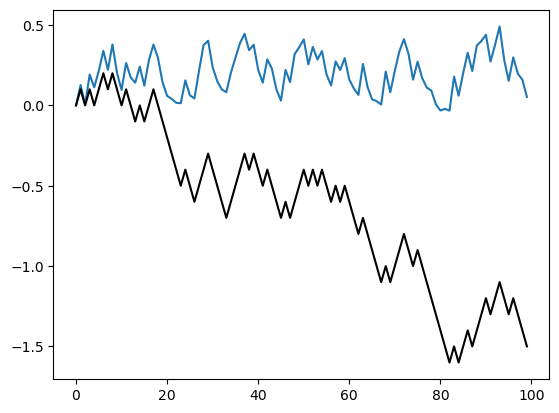

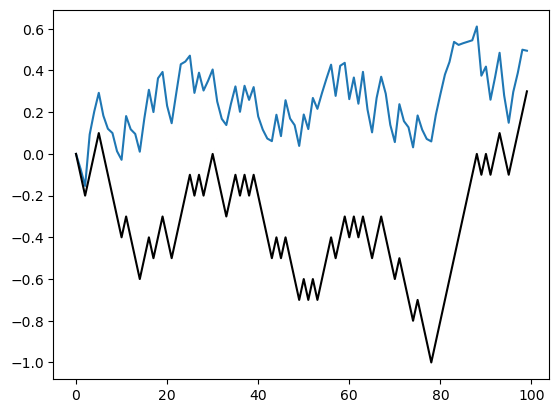

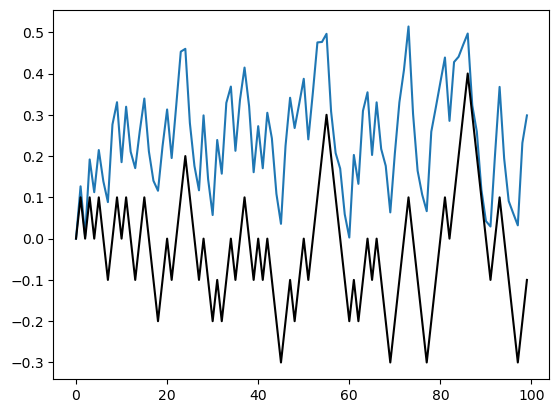

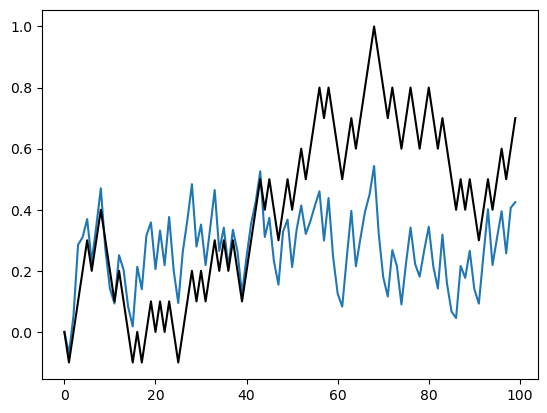

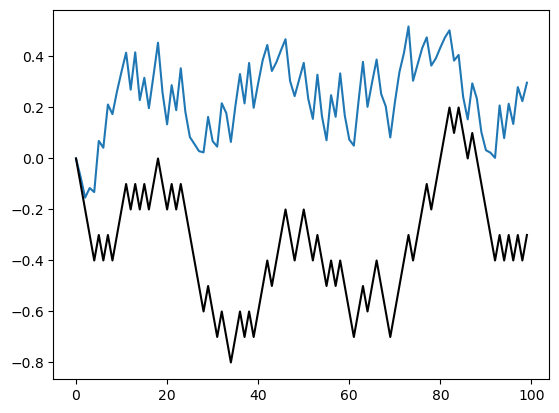

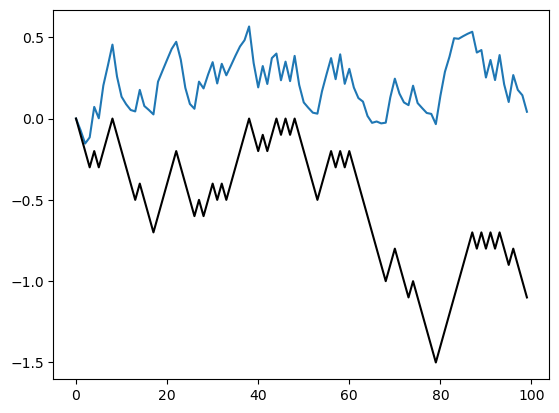

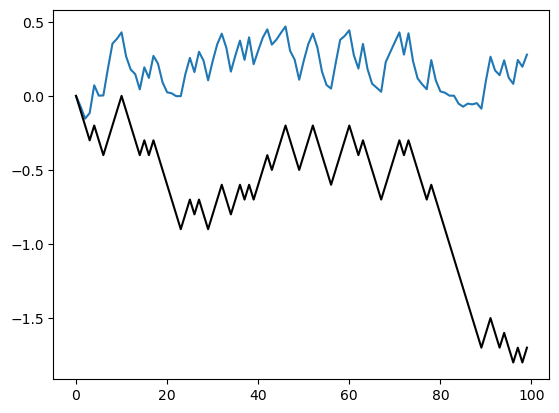

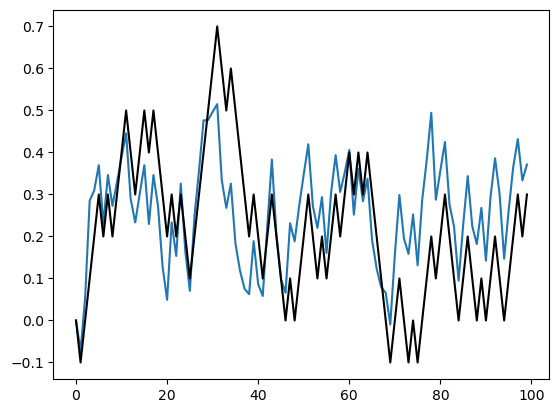

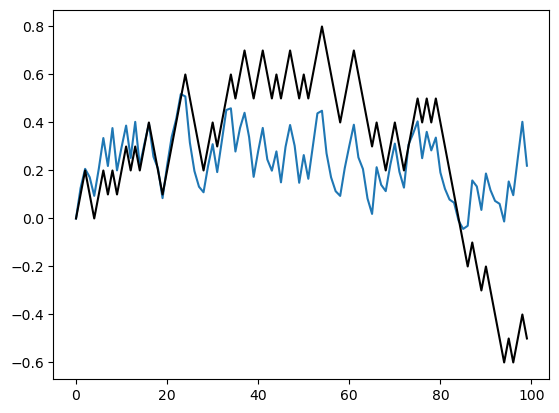

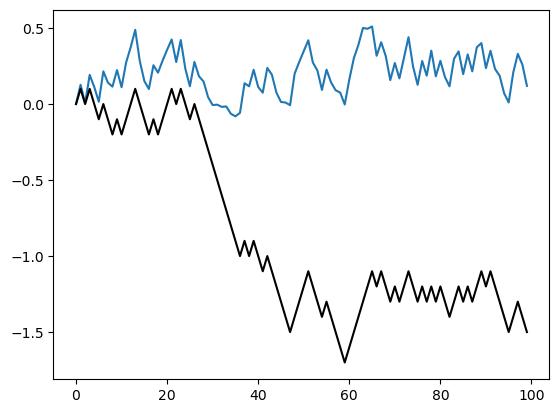

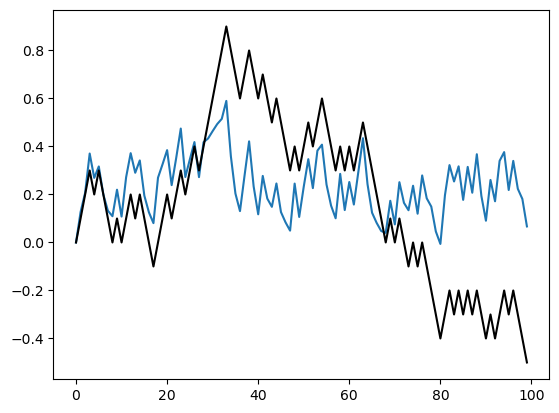

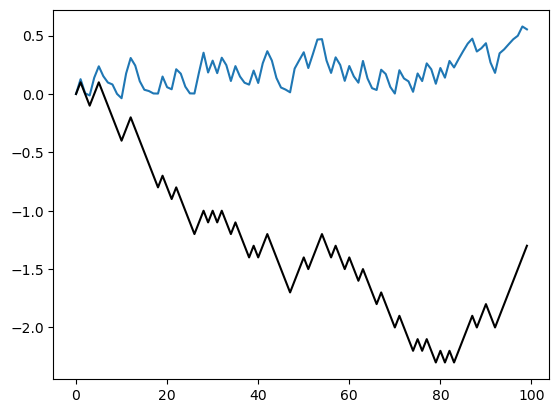

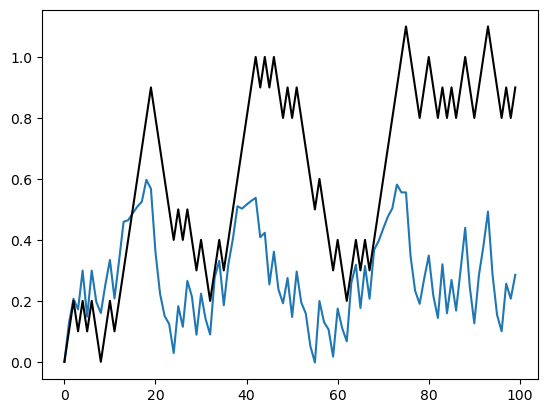

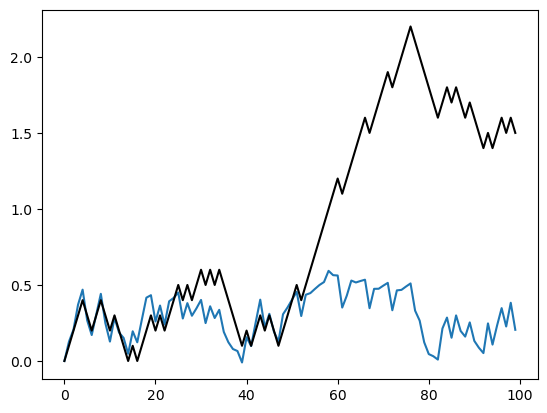

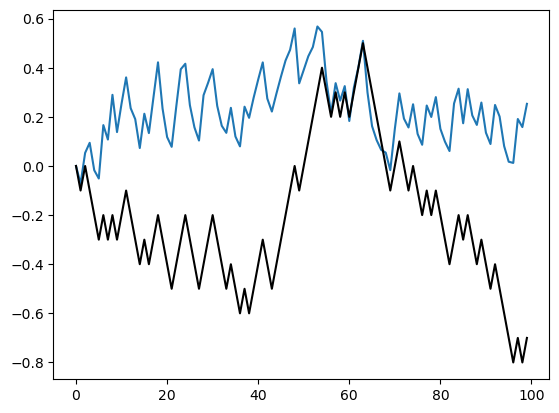

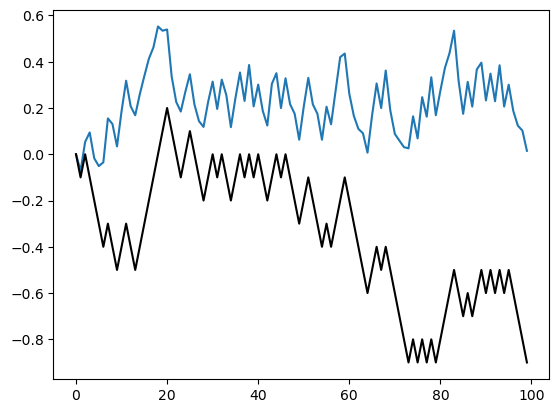

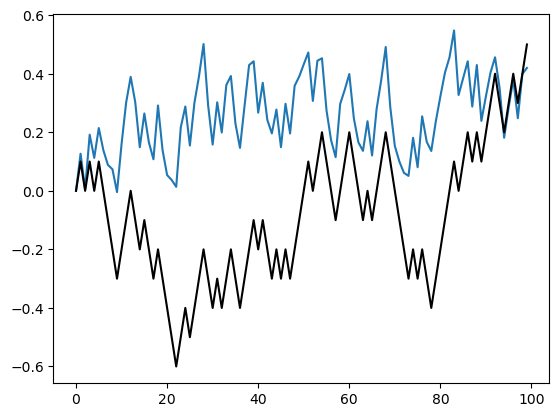

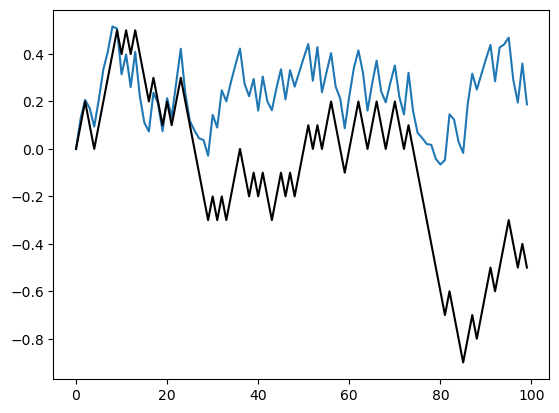

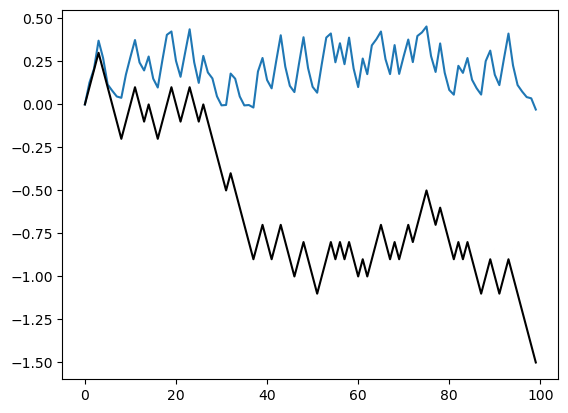

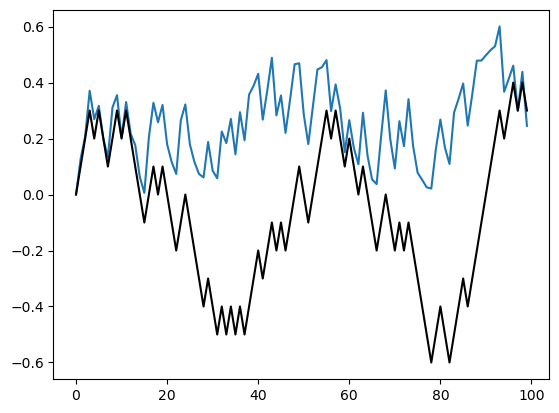

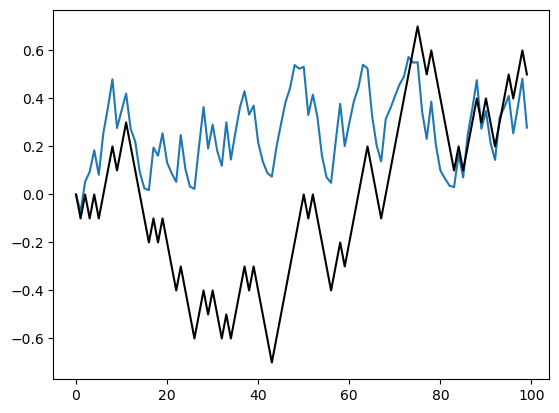

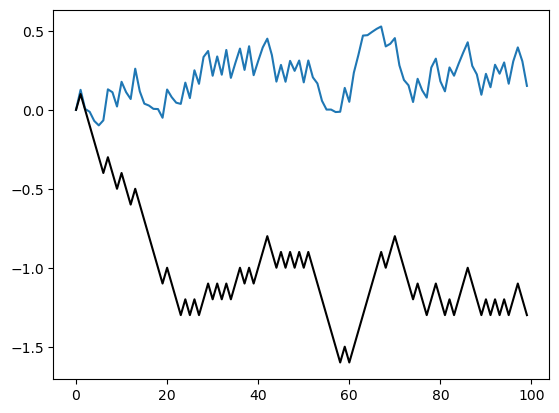

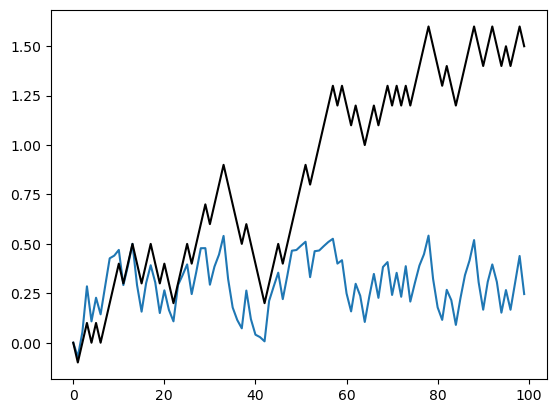

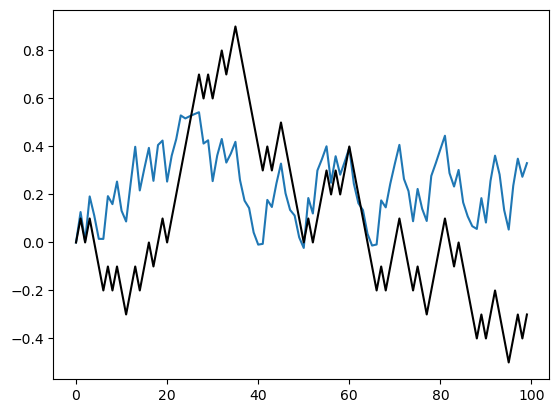

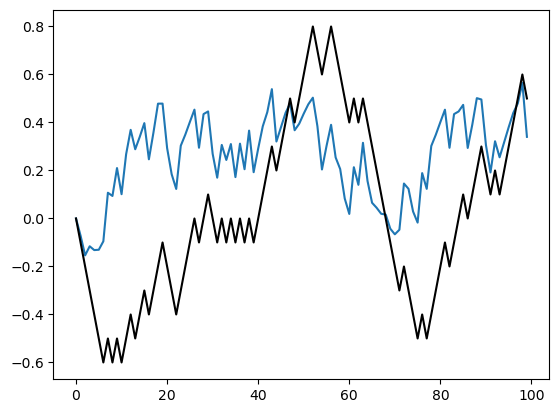

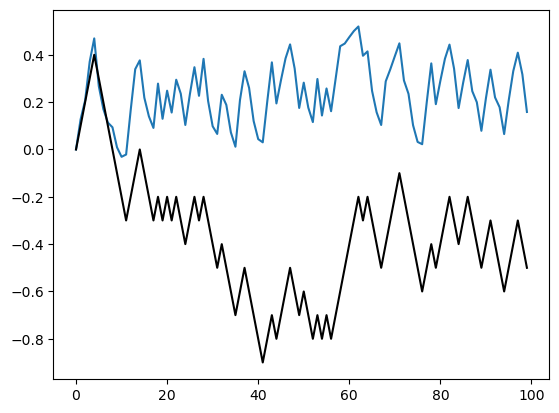

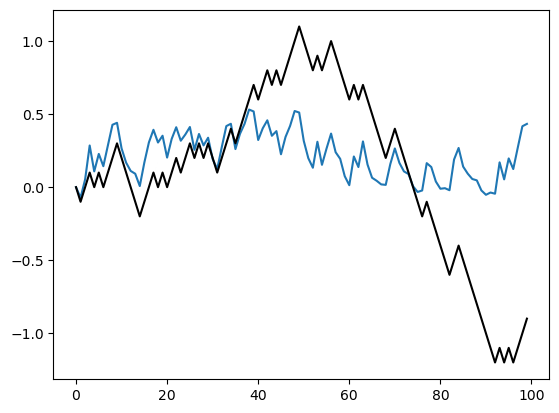

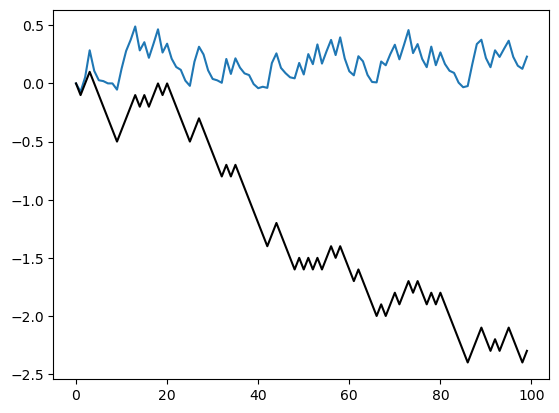

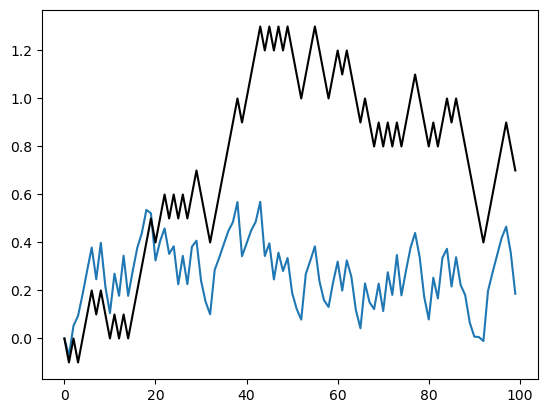

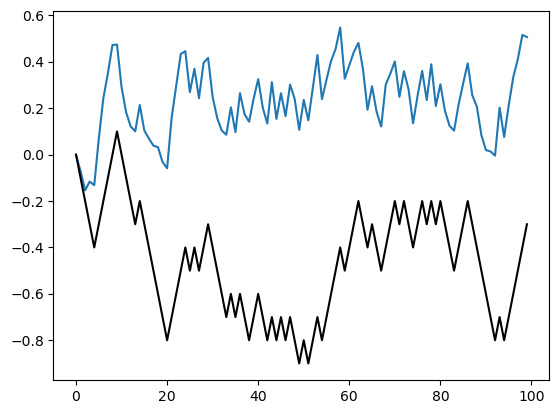

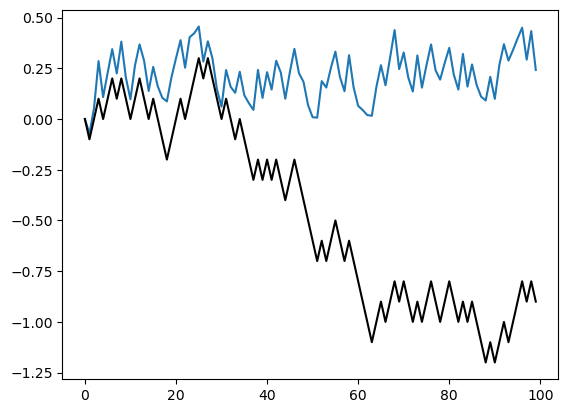

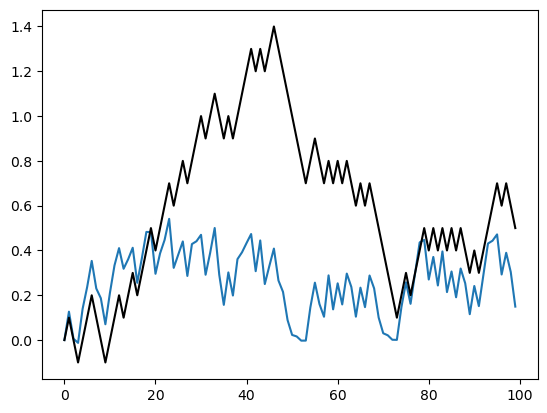

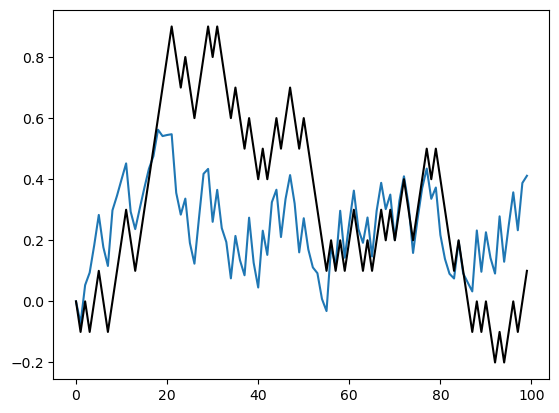

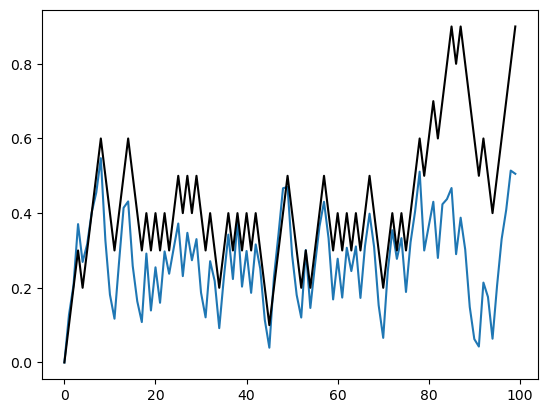

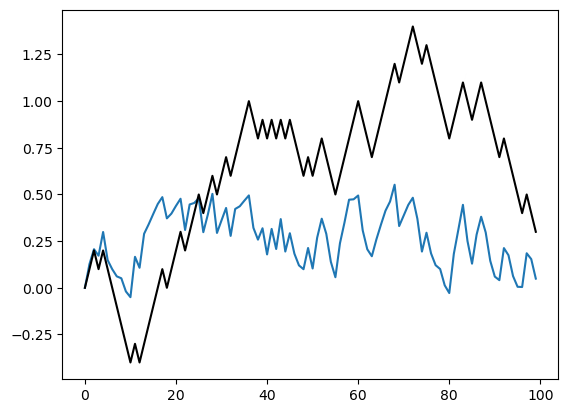

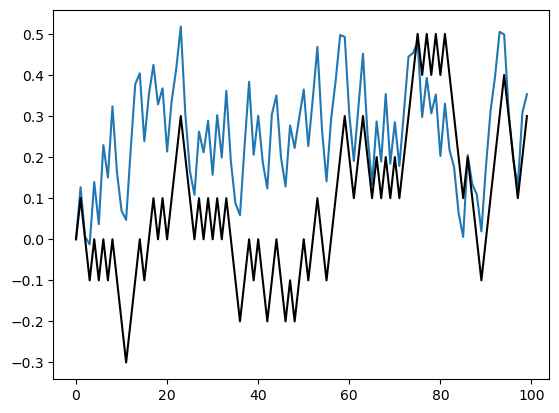

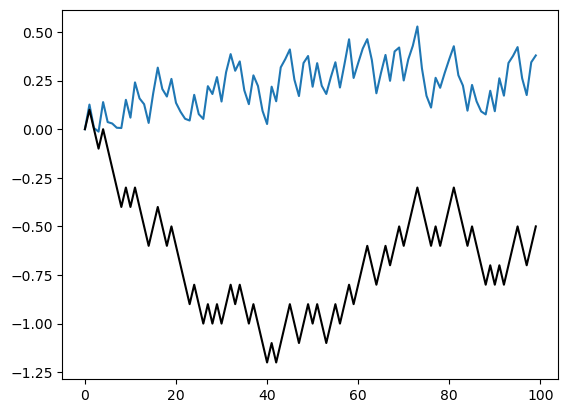

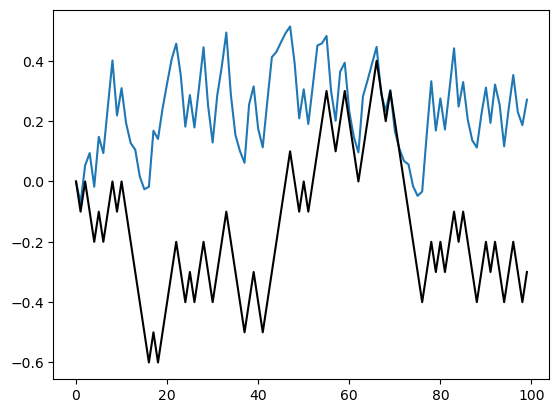

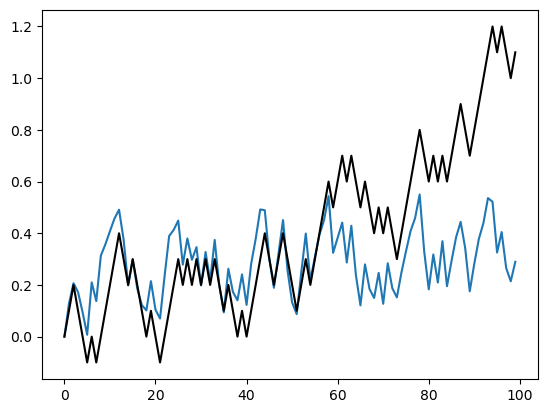

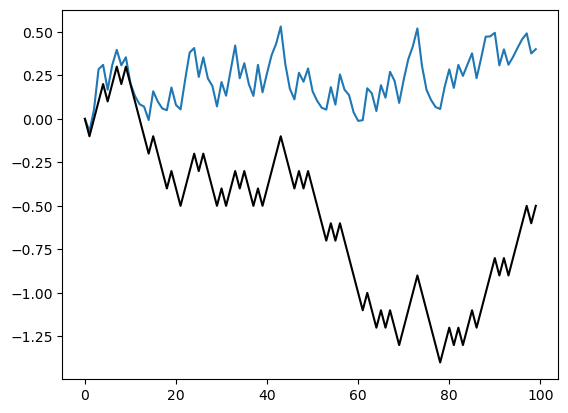

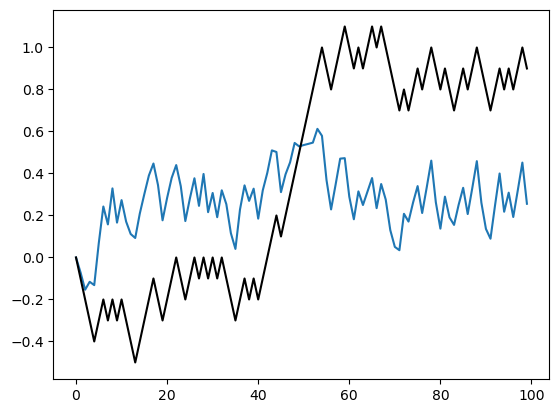

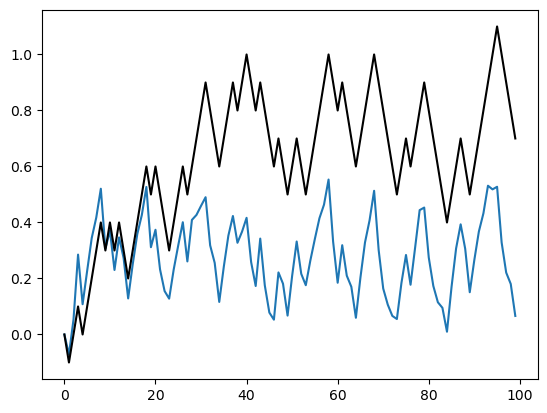

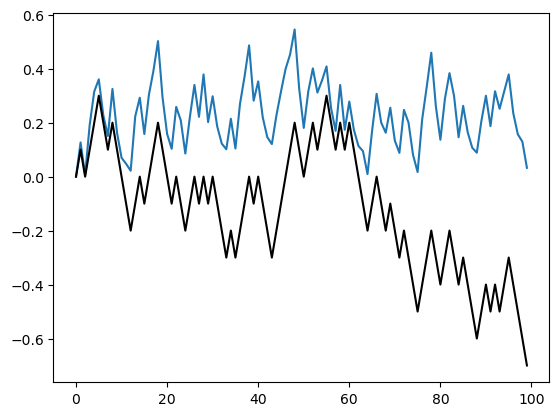

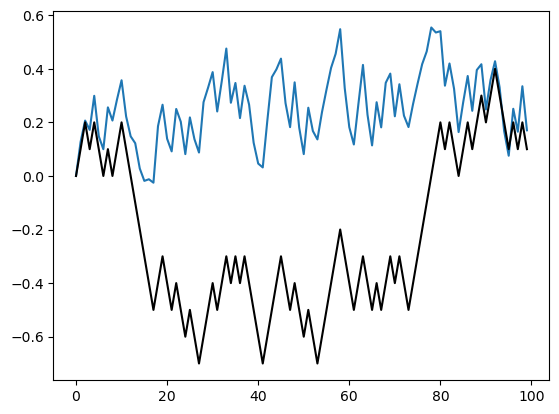

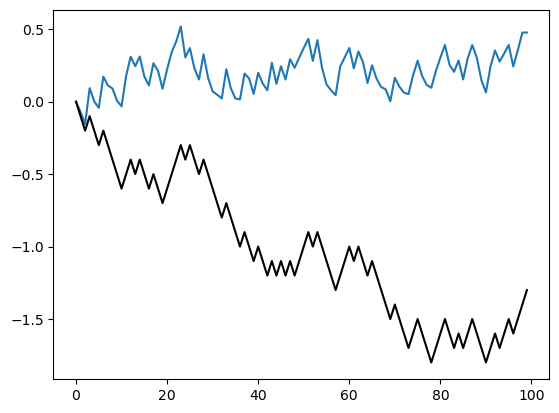

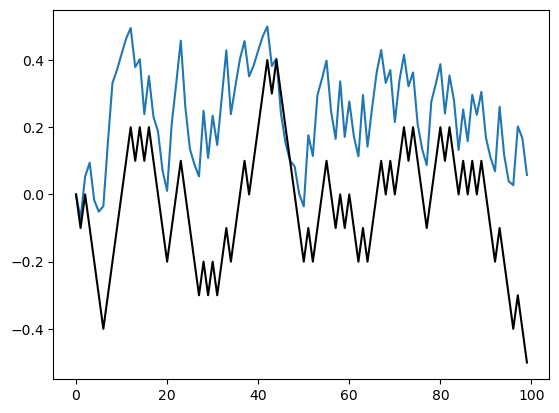

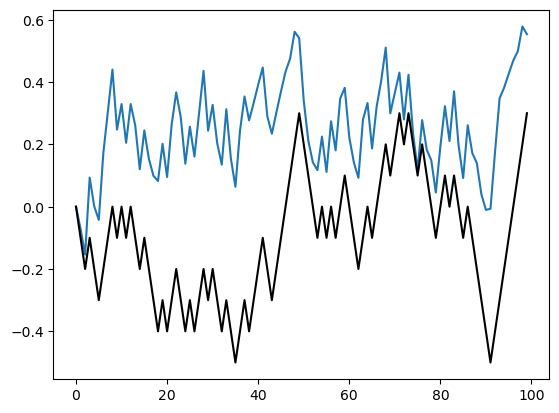

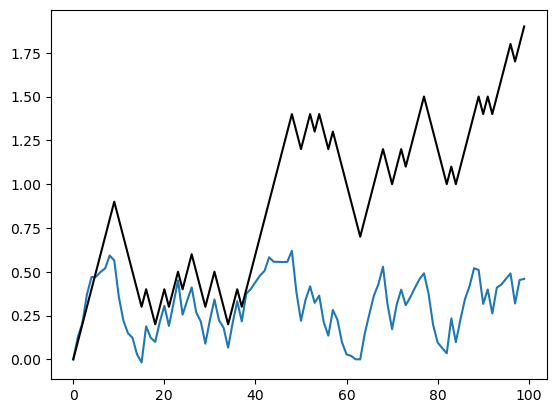

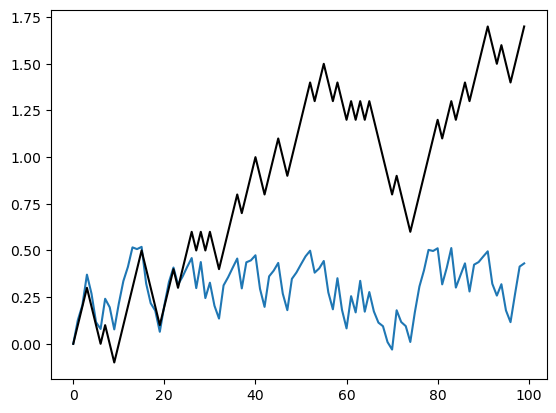

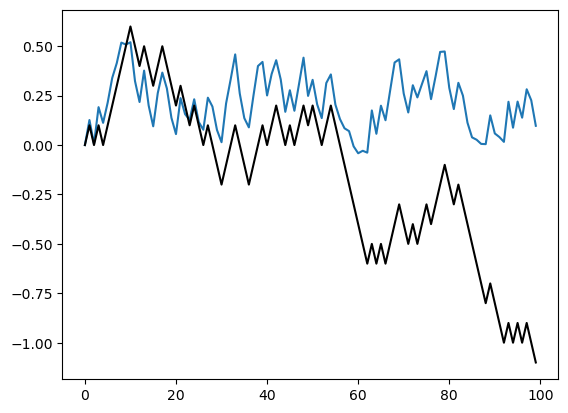

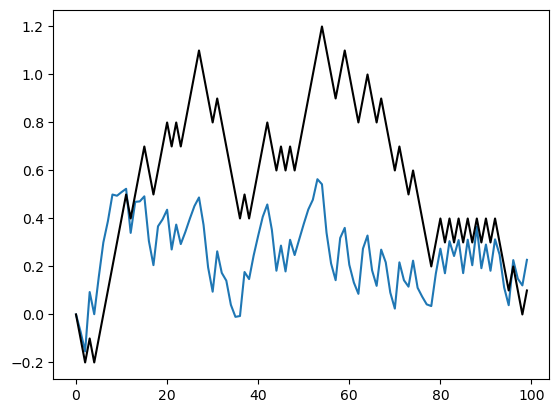

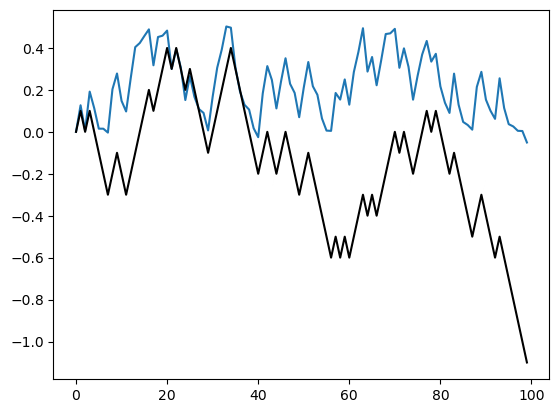

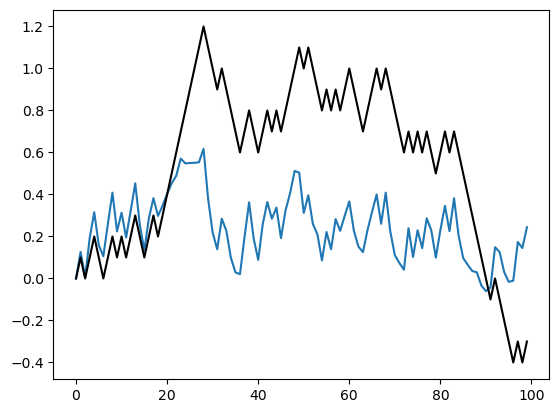

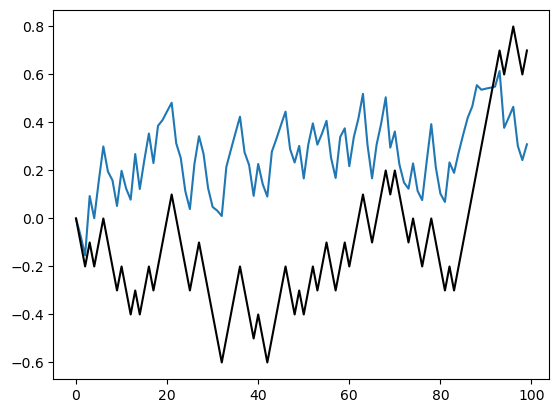

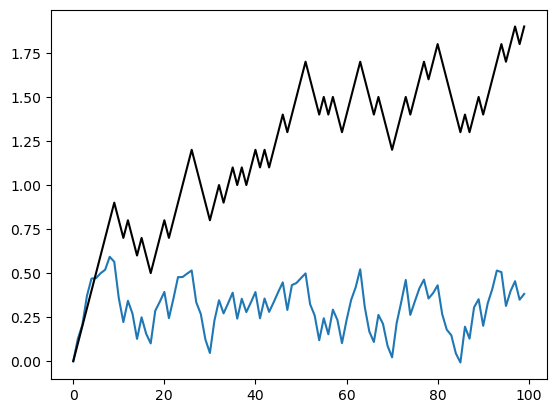

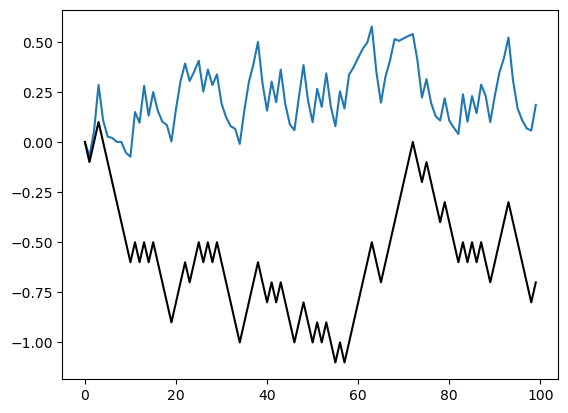

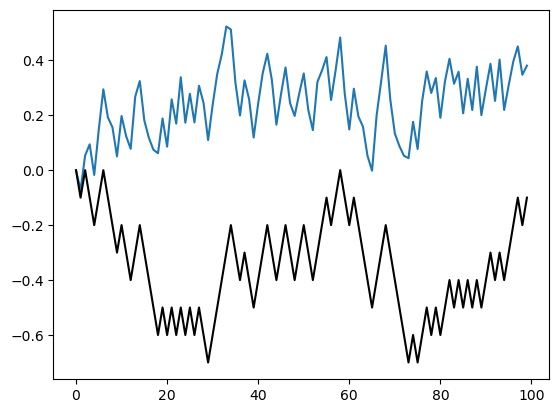

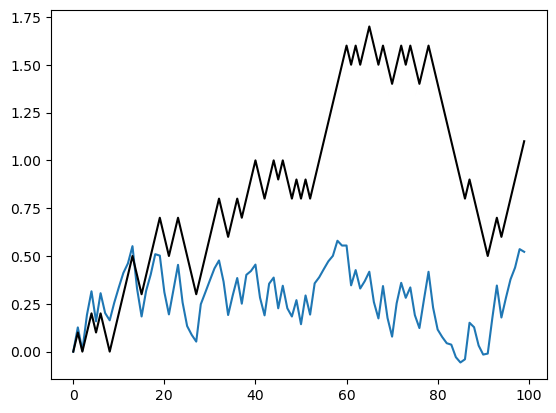

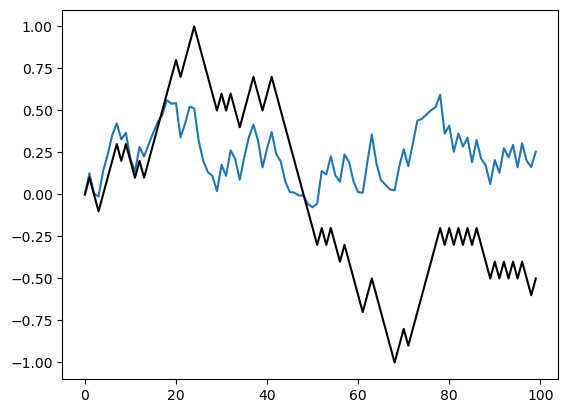

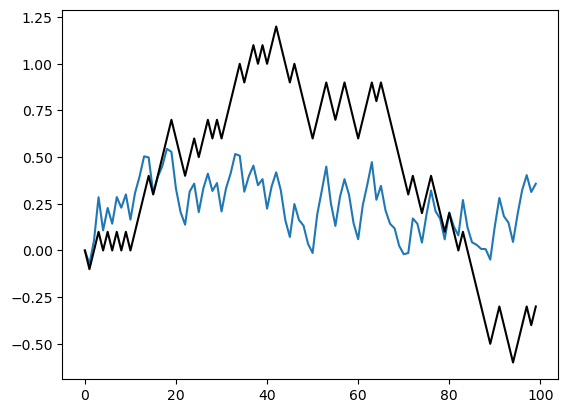

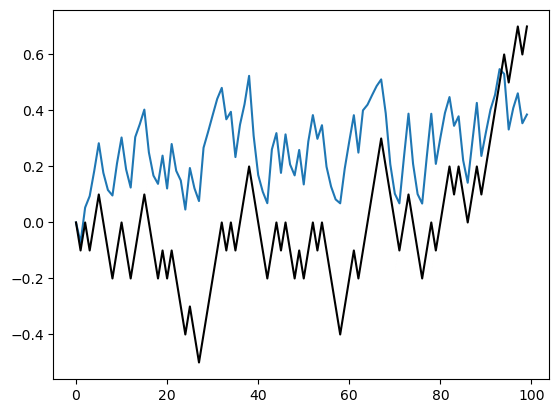

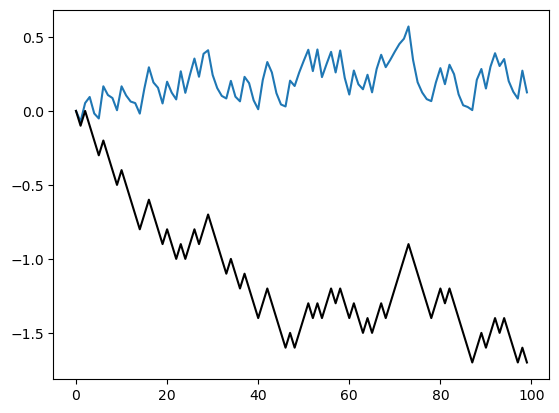

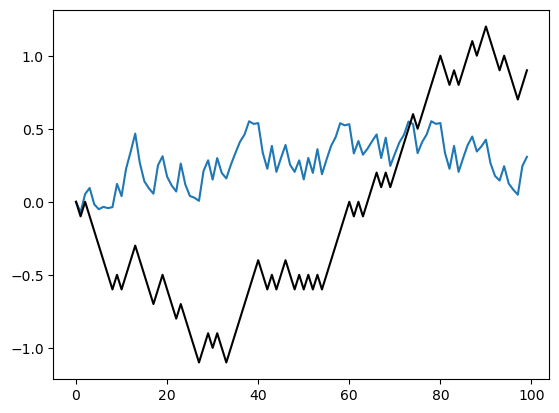

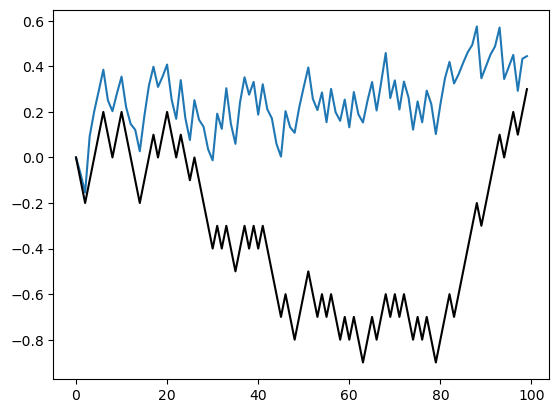

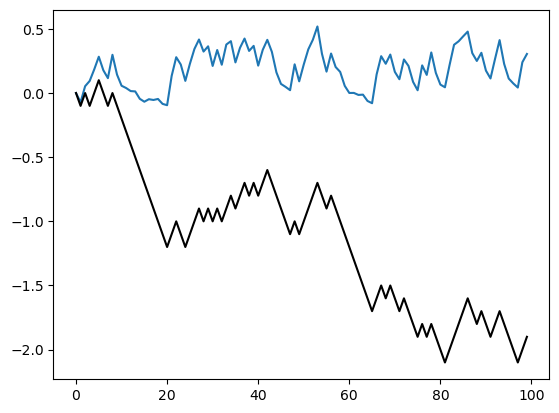

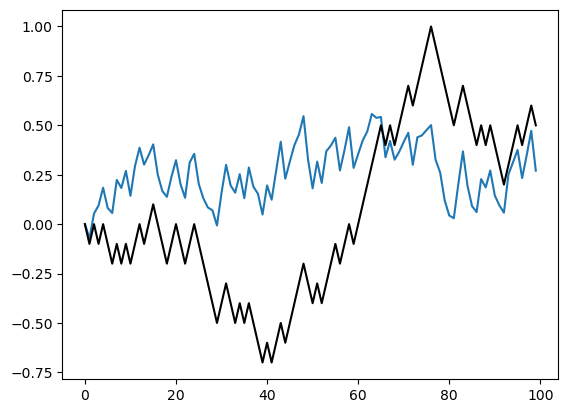

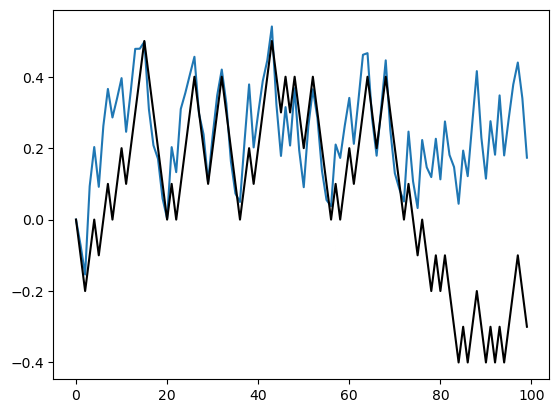

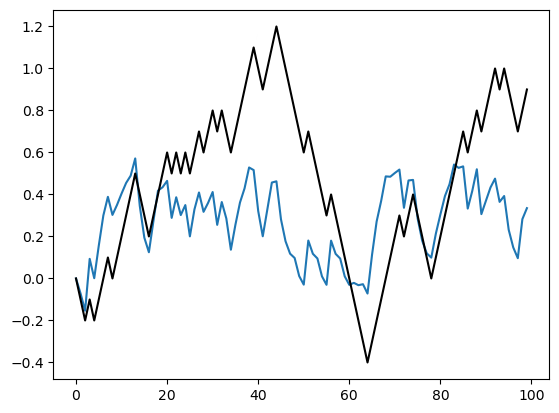

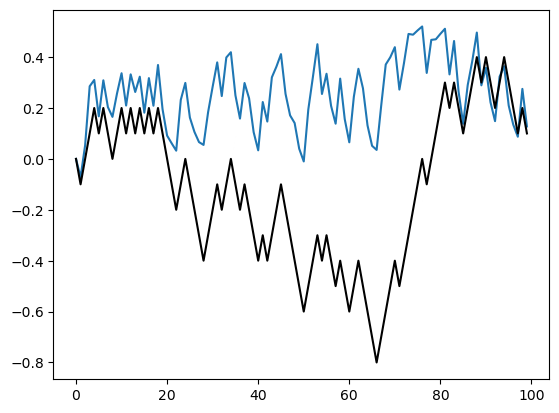

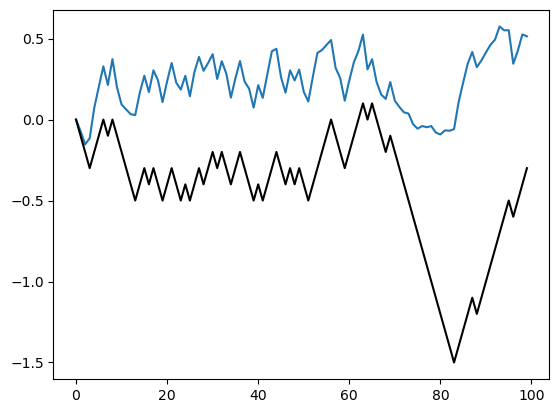

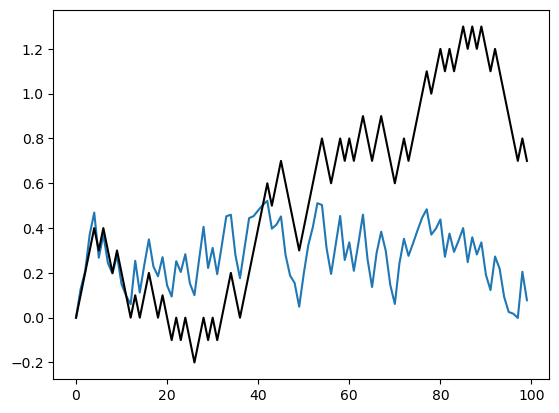

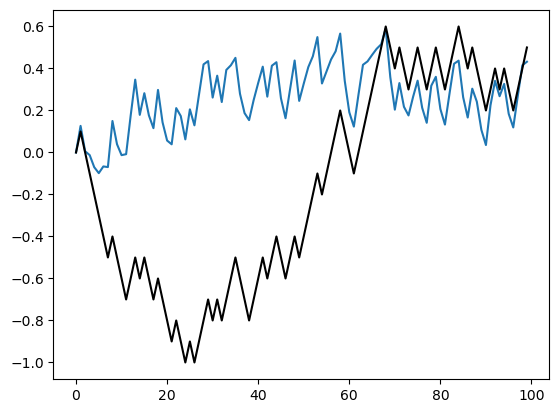

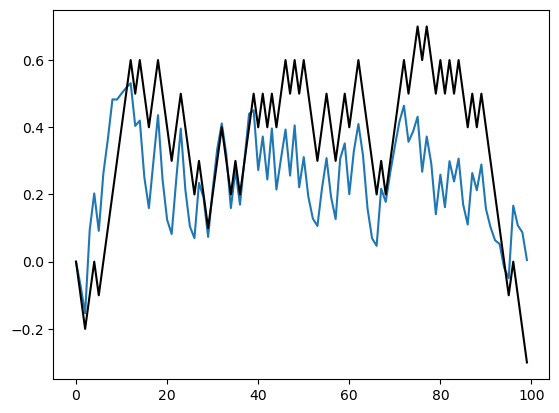

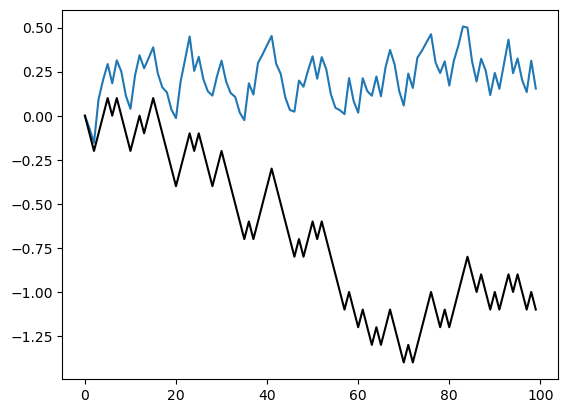

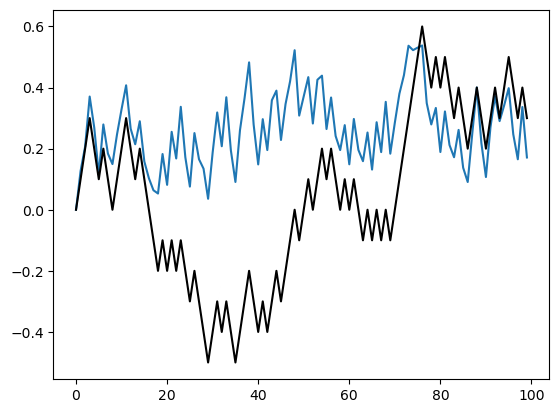

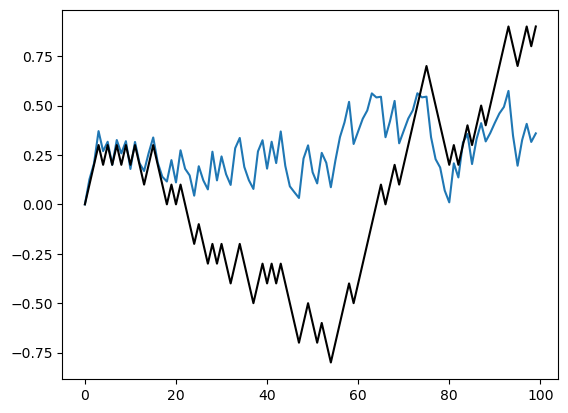

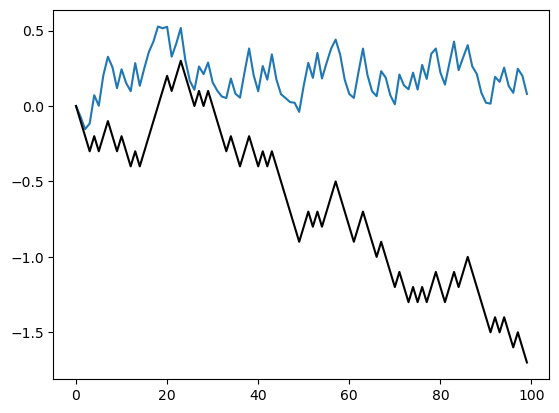

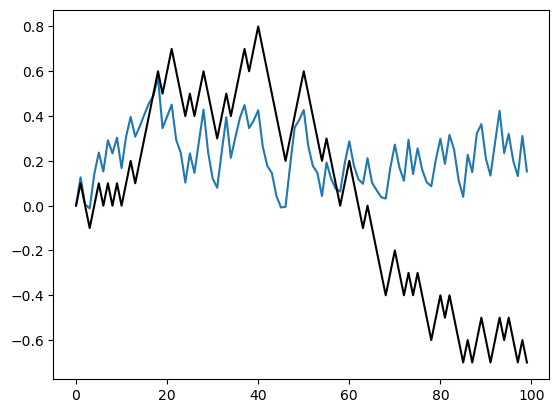

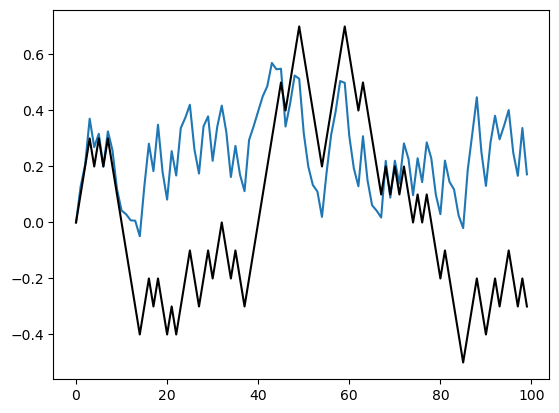

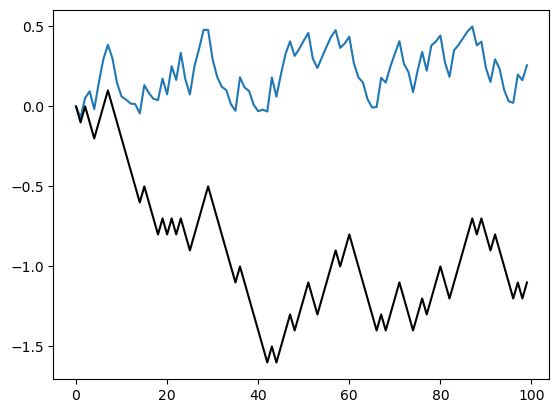

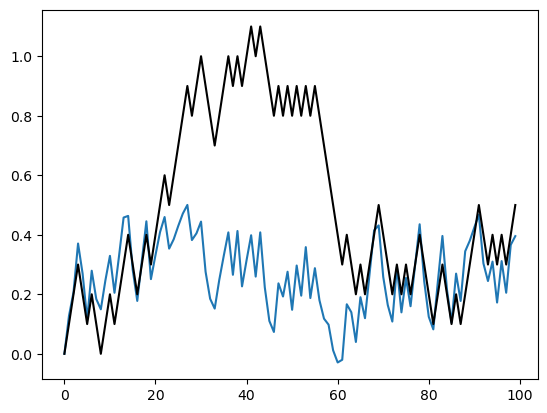

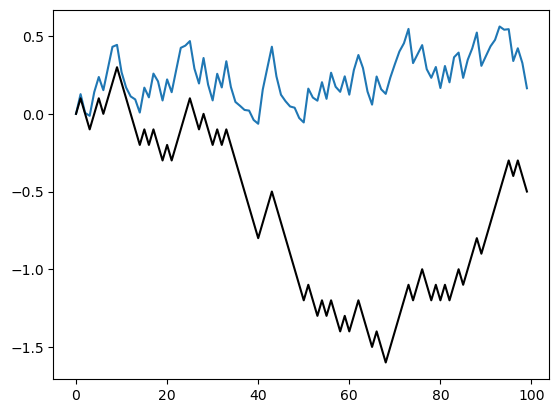

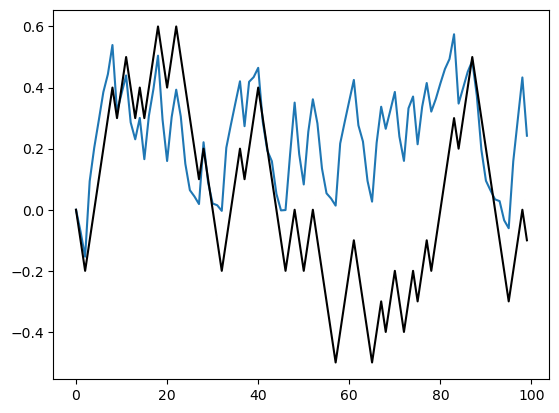

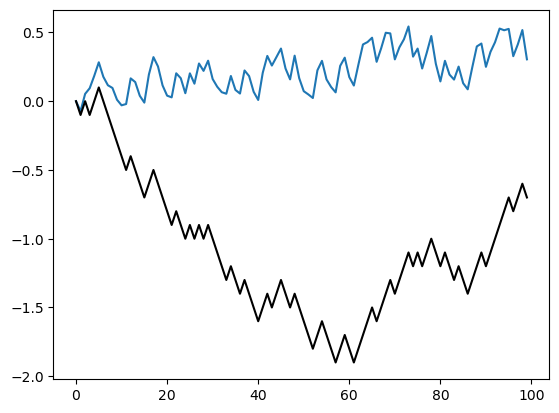

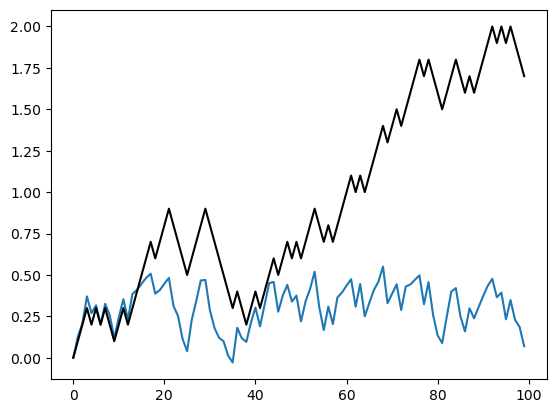

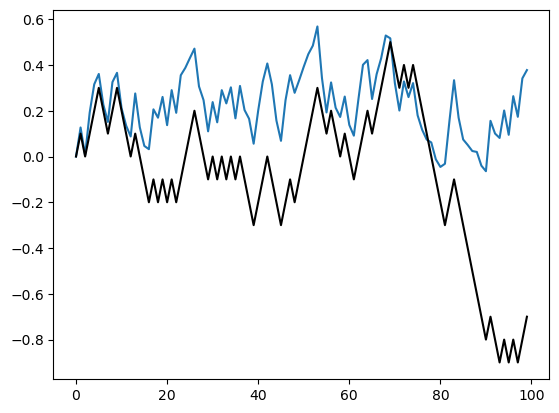

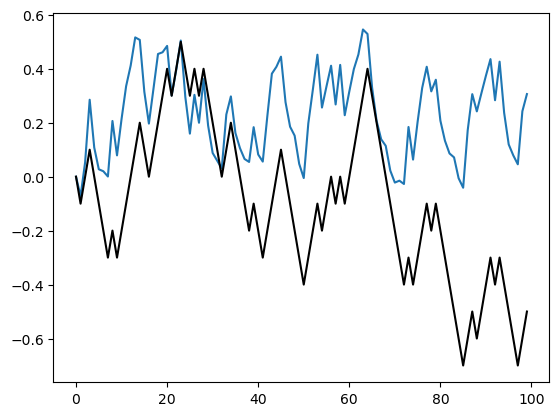

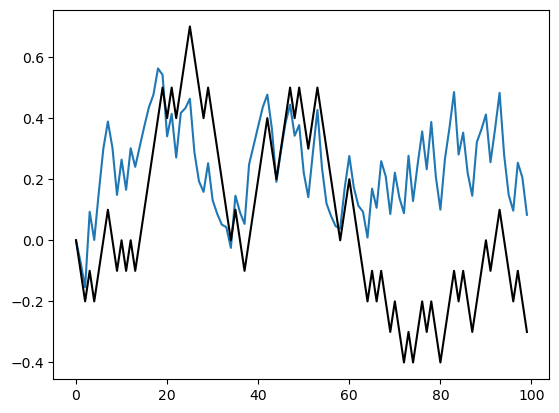

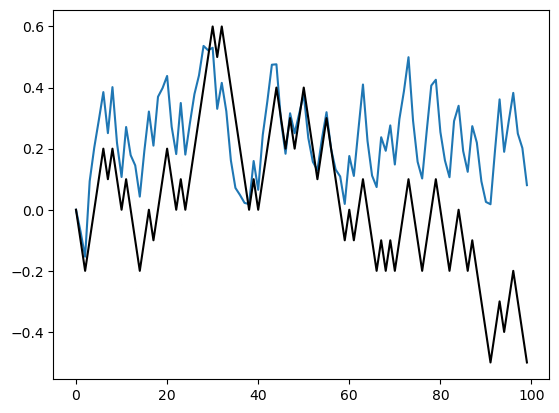

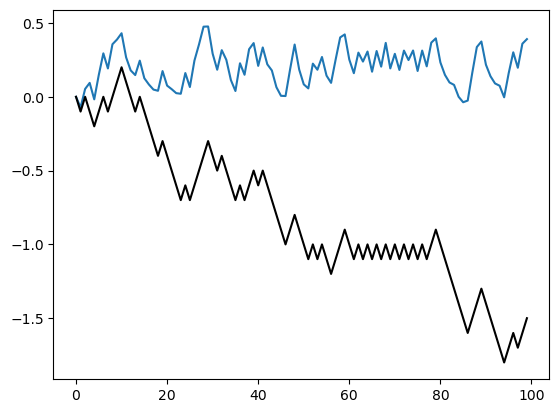

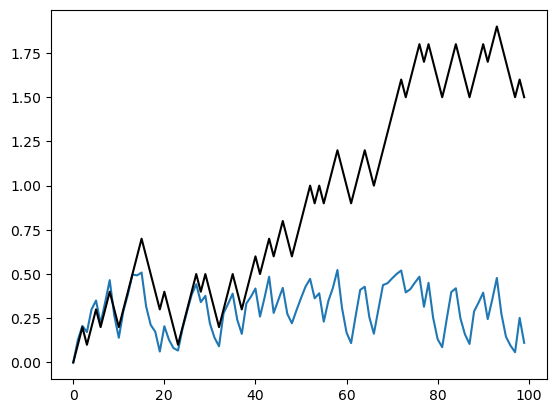

In [760]:
ko_neurons = [2]  # Example of neuron indices to zero out

# neurons to silence randomly
##############################
# percentage_silenced = 0.1  # 10% of neurons to silence randomly
# num_silenced = int(hidden_dim * percentage_silenced)
# ko_neurons = np.random.choice(hidden_dim, num_silenced, replace=False)
##############################

# find neurons with high connectivity
##############################
# connectivity_threshold = 0.169 # Example threshold for high connectivity
# weight_matrix = model.rnn.bias_hh_l0.detach().numpy()  # Example for accessing layer weights
# ko_neurons = np.where(np.abs(weight_matrix)>connectivity_threshold)[0]
##############################

# find high activity neurons
##############################
all_hidden = [] 
hid = None
for i in range(x.shape[1]):
    _, hid = model(x_tensor[:, i, :].unsqueeze(2), hid)
    all_hidden.append(hid)
ko_neurons = torch.argsort(torch.stack(all_hidden).squeeze().mean(axis=0).mean(axis=0),descending=True).detach().numpy()[:2]
##############################

 
all_output = [] 
all_hidden = [] 
hid = None
for i in range(x.shape[1]):
    out, hid = model(x_tensor[:, i, :].unsqueeze(2), hid)

    for neuron_idx in ko_neurons:
        hid[0,:,neuron_idx] = 0  # Zero out targeted neurons in the hidden state
    
    all_output.append(out)
    all_hidden.append(hid)

for T in range(x.shape[0]):
    plt.plot(torch.stack(all_output).squeeze()[:,T].detach().numpy())
    plt.plot(y_tensor.squeeze()[T,:].detach().numpy(),'k')
    plt.show()